<a href="https://colab.research.google.com/github/LiYuan199701/AMIC/blob/bayes_classification/Short_Bayes_of_classification_Twitter_AMIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Two_layer implementation of AMIC

In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 128.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 67.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
ope

# Print out Faster GPUs and Higher Memory

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Wed Oct  8 15:15:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   37C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Basic package loading and import torch

In [ ]:
import pyximport
import os
import IPython
import Cython
import sys
import os
import numpy as np
import pandas as pd
import copy
import scipy
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import random, math, sys, string, re
%matplotlib inline
# Set inline backend and resolution
%config InlineBackend.figure_format = 'retina'  # For Retina displays
plt.rcParams['figure.dpi'] = 100  # Set dpi to 200 for high resolution

# Import keras and tensorflow
#from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.preprocessing.sequence import pad_sequences

# Split dataset into train, val, test
from sklearn.model_selection import train_test_split

# Import Torch Package and its functions
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
torch.__version__

'2.8.0+cu126'

# Mount Google Driver, Read in Data Set from my Google Driver

In [ ]:
from datasets import load_dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# 0) Mount Google Driver
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# Change to my project directory
os.chdir('/content/drive/MyDrive/AMIC project')

# 1) Load
raw = load_dataset("cardiffnlp/tweet_eval", "sentiment")  # splits: train/validation/test

# 2) Make it binary (drop neutral) -> y: 0/1
def split_to_xy(ds_split):
    lbl = np.array(ds_split["label"])
    txt = np.array(ds_split["text"])
    keep = lbl != 1                    # drop neutrals
    y = (lbl[keep] == 2).astype("int64")  # 2 -> positive
    x = txt[keep]
    return x, y

train_texts, train_y = split_to_xy(raw["train"])
val_texts,   val_y   = split_to_xy(raw["validation"])
test_texts,  test_y  = split_to_xy(raw["test"])

def build_merged_df(train_texts, train_y, val_texts, val_y, test_texts, test_y,
                    text_col="Clean_desc", label_col="y"):
    def to_df(texts, y, split_name):
        return pd.DataFrame({
            text_col: list(texts),
            label_col: pd.Series(np.asarray(y), dtype="int64"),
            "split": split_name
        })

    df_train = to_df(train_texts, train_y, "train")
    df_val   = to_df(val_texts,   val_y,   "validation")
    df_test  = to_df(test_texts,  test_y,  "test")

    df = pd.concat([df_train, df_val, df_test], ignore_index=True)

    # Empty rating column (nullable integer). Use pd.NA to indicate missing.
    df["rating"] = pd.Series([pd.NA] * len(df), dtype="Int64")

    # Optional: shuffle for any downstream random sampling
    # df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    return df

# usage:
df = build_merged_df(train_texts, train_y, val_texts, val_y, test_texts, test_y)
print(df.shape)
#df.head()

# 6) Check review lengths
# A2) Length helpers
def add_length_columns(df, text_col="Clean_desc"):
    df = df.copy()
    df["n_words"] = df[text_col].str.split().apply(len)
    df["n_chars"] = df[text_col].str.len()
    return df

def describe_lengths(series):
    qs = [0.5, 0.75, 0.9, 0.95, 0.99]
    out = {
        "count": int(series.size),
        "mean": float(series.mean()),
        "std": float(series.std(ddof=1)),
        "min": int(series.min()),
        "max": int(series.max()),
    }
    for q in qs:
        out[f"q{int(q*100)}"] = float(series.quantile(q))
    return out

def pad_coverage(series, pad_sizes=(10, 30, 50, 70, 90, 110, 128, 192, 224, 256, 300, 384, 512, 768)):
    return {ps: float((series <= ps).mean()) for ps in pad_sizes}

# A3) Compute
df = add_length_columns(df)
df_words = df["n_words"]
print("DF word-length summary:", describe_lengths(df_words))

print("\nCoverage (train) for common pad sizes:")
print(pad_coverage(df_words,
      pad_sizes=(10, 30, 50, 70, 90, 110, 128, 192, 224, 256, 300, 384, 512, 768)))

# A4) Optional: quick histogram plots
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(df_words, bins=50, alpha=0.7)
plt.xlabel("Words per review"); plt.ylabel("Count"); plt.title("Twitter: Review Length (words)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.hist(df_words, bins=np.arange(0, 1200, 20), alpha=0.7)
plt.yscale("log"); plt.xlabel("Words per review"); plt.ylabel("Count (log scale)")
plt.title("Twitter: Review Length (words, log scale)")
plt.tight_layout(); plt.show()

df

# Preprocess Tweets

In [ ]:
import re
import html
from typing import List

EMOTICONS = {
    r":\)": ":smile:", r":D": ":grin:", r":\(": ":sad:",
    r";\)": ":wink:", r"<3": ":heart:", r":P": ":playful:"
}
EMOT_RE = re.compile("|".join(map(re.escape, EMOTICONS.keys())))

URL_RE   = re.compile(r"https?://\S+|www\.\S+", re.I)
USER_RE  = re.compile(r"@\w+")
NUM_RE   = re.compile(r"\b\d+(?:[\.,]\d+)*\b")
MULTI_QE = re.compile(r"([!?]){2,}")
ELONG_RE = re.compile(r"(.)\1{2,}", re.UNICODE)  # 3+ repeats
HASHTAG_RE = re.compile(r"#(\w+)")
PUNCT_SPACE_RE = re.compile(r"\s+")
NEGATIONS = re.compile(r"\b(?:no|not|never|n't)\b", re.I)

def _split_hashtag(tag: str) -> List[str]:
    # Simple camel/snake split; replace with wordsegment for better results
    parts = re.sub(r"([a-z])([A-Z])", r"\1 \2", tag).replace("_", " ").lower().split()
    return parts if parts else [tag.lower()]

def normalize_tweet(text: str, keep_caps_emphasis: bool=False) -> str:
    # 1) HTML entities
    text = html.unescape(text)

    # 2) Replace URLs, users, numbers
    text = URL_RE.sub("<url>", text)
    text = USER_RE.sub("<user>", text)
    text = NUM_RE.sub("<number>", text)

    # 3) Emoticons (before lowercasing)
    def repl_emot(m):
        return EMOTICONS.get(m.group(0), m.group(0))
    text = EMOT_RE.sub(repl_emot, text)

    # 4) Lowercase (optional caps emphasis)
    if not keep_caps_emphasis:
        text = text.lower()

    # 5) Hashtags → split + keep joined token
    def repl_hash(m):
        tag = m.group(1)
        parts = _split_hashtag(tag)
        return "#"+tag.lower()+" " + " ".join(parts)
    text = HASHTAG_RE.sub(repl_hash, text)

    # 6) Elongations: coolll → cool (keep marker)
    def repl_elong(m):
        ch = m.group(1)
        return ch * 2  # cap to 2
    elongated = 1 if ELONG_RE.search(text) else 0
    text = ELONG_RE.sub(repl_elong, text)
    if elongated:
        text += " <elongated>"

    # 7) Emphasis counts
    text = MULTI_QE.sub(lambda m: f" {m.group(1)} <emph>", text)

    # 8) Negation scope (lightweight)
    tokens = text.split()
    out = []
    negate = False
    for tok in tokens:
        if NEGATIONS.match(tok):
            negate = True
            out.append(tok)
            continue
        if re.search(r"[.!?]", tok):
            out.append(tok + ("_NEG" if negate else ""))
            negate = False
        else:
            out.append(tok + ("_NEG" if negate else ""))
    text = " ".join(out)

    # 9) Collapse spaces
    text = PUNCT_SPACE_RE.sub(" ", text).strip()
    return text

# Example
tw = "@user miss ya to buddy &lt;3 what you saying Monday night ? Down for The Kee wtb #HollaAtMe"
#print(normalize_tweet(tw))
# apply normalize_tweet to the Clean_desc column in df
df['Clean_desc_pre'] = df['Clean_desc'].apply(normalize_tweet)
df[['Clean_desc_pre', 'Clean_desc', 'y']]

,Clean_desc_pre,Clean_desc,y
0,"""qt <user> in the original draft of the 7th bo...","""QT @user In the original draft of the 7th boo...",1
1,<user> alciato: bee will invest <number> milli...,@user Alciato: Bee will invest 150 million in ...,1
2,<user> lit my mum 'kerry the louboutins i wond...,@user LIT MY MUM 'Kerry the louboutins I wonde...,1
3,"""\"""" soul train\"""" oct <number> halloween spec...","""\"""""""" SOUL TRAIN\"""""""" OCT 27 HALLOWEEN SPECIA...",1
4,so disappointed in wwe summerslam! i want to s...,So disappointed in wwe summerslam! I want to s...,0
...,...,...,...
32415,<user> for al the crying you do about how midd...,@user for al the crying you do about how middl...,0
32416,"i'm not even_NEG catholic,_NEG but_NEG pope_NE...","i'm not even catholic, but pope francis is my ...",1
32417,<user> <user> <user> looks like flynn isn't to...,@user @user @user Looks like Flynn isn't too p...,0
32418,trying to have a conversation with my dad abou...,Trying to have a conversation with my dad abou...,0


# The Whole Pre-Process the Dataset

<timed exec>:11: RuntimeWarning: invalid value encountered in cast


train index:  [12178, 17387, 18244, 3785, 22242, 25382, 2030, 26024, 14779, 31332]
valid index:  [18817, 11498, 18814, 2968, 2175, 21045, 8450, 10603, 5050, 27593]
test index:  [21687, 9508, 24957, 15390, 1272, 27260, 30681, 31573, 27433, 18049]
Loaded 400000 word vectors from glove.
Found 37307 unique tokens. 

(37307, 300) 

Word Index list:  ['neg', 'the', 'user', 'to', 'i'] 

Wine Sentence Token:  [['rt', 'user', 'jeopardy', 'jeopardy', 'where', 'everyone', 'will', 'be', 'watching', 'the', 'ravens', 'vs', 'eagles', 'game', 'this', 'thursday', 'what', 'is', 'user', 'goodanswer', 'goodanswer', 'elongated']] 

Found 25906 unique tokens.
(25906, 300)
Show length vector:  [[20]
 [24]
 [25]
 ...
 [13]
 [12]
 [24]] 

Show token id for 1st sentence:  [244, 3, 6842, 6842, 223, 207, 34, 17, 142, 2, 2504, 217, 783, 76, 24, 103, 64, 12, 3, 14] 

Show the Max token id of all corpus:  25906 



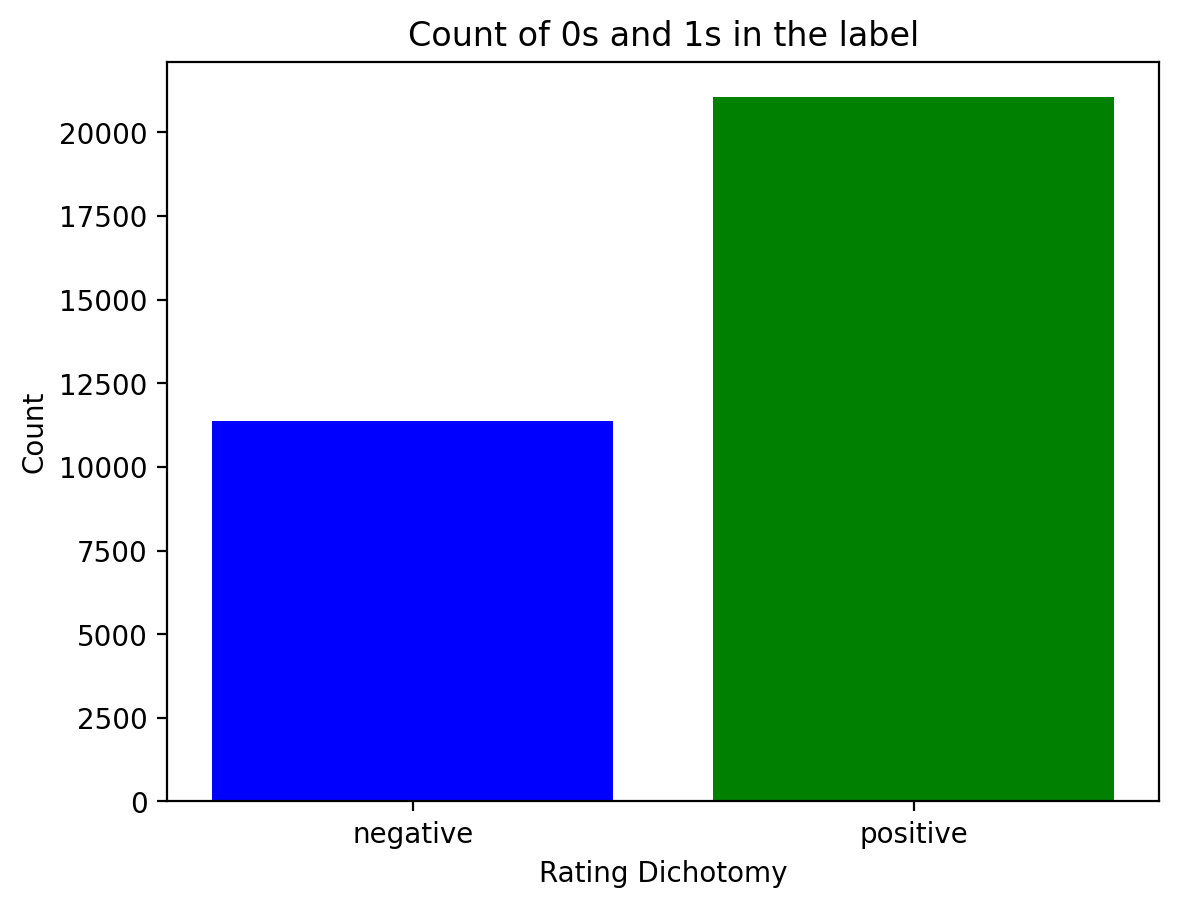

<Figure size 700x400 with 0 Axes>

outcome y label length:  32420 

Print padded Embedding shape:  (32420, 50) 

train_x shape:  (29178, 51)
train_y shape:  (29178,)
valid_x shape:  (1621, 51)
valid_y shape:  (1621,)
test_x shape:  (1621, 51)
test_y shape:  (1621,)
Sample X size: torch.Size([32, 51])
Sample Y size: torch.Size([32])
Sample rating size: torch.Size([32])
First ratings in batch: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
Embedding Size:  300 

Embedding Matrix Size:  (25906, 300) 

Embedding Matrix size with zero (25907, 300)
CPU times: user 59.1 s, sys: 1.15 s, total: 1min
Wall time: 1min 1s


In [ ]:
%%time
# Split Dataset================================================================
#==============================================================================
# Shuffle the wine review dataset
ds=df.sample(frac=1, random_state=42).copy()

#y = (ds['rating']>89).astype(int).values
# assign column Sentiment to be y
y = ds['y'].values

# Keep the raw rating (80–100) for analysis
ratings = ds['rating'].to_numpy().astype(np.int16)

# Set a seed to torch functions for reproduce
SEED = 2022
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

indices = range(len(y))
train_index, valid_index = train_test_split(indices, test_size=0.1, random_state = SEED)
valid_index, test_index = train_test_split(valid_index, test_size=0.5, random_state = SEED)
print("train index: ", train_index[:10])
print("valid index: ", valid_index[:10])
print("test index: ", test_index[:10])

# Get the train, dev and test ratings
train_r = ratings[list(train_index)]
valid_r = ratings[list(valid_index)]
test_r  = ratings[list(test_index)]

# Preprocess the dataset ======================================================
#==============================================================================

# --- before you fit the tokenizer ---
text_col  = 'Clean_desc_pre'
label_col = 'y'  # your merged df likely used 'labels'

# Drop missing/blank texts
ds = ds.dropna(subset=[text_col]).copy()
ds[text_col] = ds[text_col].astype(str).str.strip()
ds = ds.loc[ds[text_col].str.len() > 0].copy()

# Labels
y = ds[label_col].to_numpy().astype(np.int64)

# Ratings (Twitter likely has NA). Keep as -1 sentinel so downstream code won’t crash.
if 'rating' in ds.columns:
    ratings = (ds['rating'].astype('Int64')
                         .fillna(-1)
                         .to_numpy(dtype=np.int32))
else:
    import numpy as np
    ratings = np.full(len(ds), -1, dtype=np.int32)


## Creat a tokenizer object and word index
#==============================================================================
# assign a string to be indicated as a variable name
#text_col = 'Clean_desc_pre'
#text_col = 'processed_text'
#tokenizer = Tokenizer(num_words=max_features)
maxlen=150
tokenizer = Tokenizer()
#Indexing words based on the whole corpus (prior to split)
tokenizer.fit_on_texts(ds[text_col])
#tokenizer.fit_on_texts(ds['Clean_desc'])
#tokenizer.fit_on_texts(ds['clean_desc_v5'])
wine_corpus= tokenizer.texts_to_sequences(ds[text_col])
#wine_corpus= tokenizer.texts_to_sequences(ds['Clean_desc'])
#wine_corpus= tokenizer.texts_to_sequences(ds['clean_desc_v5'])
train_word_index=tokenizer.word_index

## Create an id and word dictionary
#==============================================================================
tokenizer.word_index
wine_id2word=dict(zip(tokenizer.word_index.values(),tokenizer.word_index.keys()))
# Display
dict(list(wine_id2word.items())[:10])

## Initialize a word embedding dictionary with a pretrained word embedding file
#==============================================================================
import os
import numpy as np
import pickle
from gensim.models import Word2Vec, FastText

def load_embeddings(kind: str, path: str):
    """
    Load word embeddings of various types into a dict {word: vector}.

    Parameters
    ----------
    kind : str
        One of: 'glove', 'word2vec', 'fasttext', 'bert'.
    path : str
        For 'glove': path to the glove .txt file.
        For 'word2vec': path to the .model file.
        For 'fasttext': path to the .model file.
        For 'bert': path to the pickle .pkl file containing a dict {word: array}.

    Returns
    -------
    embeddings_index : dict
        Mapping from token to its embedding (np.array of dtype float32).
    """
    embeddings_index = {}

    if kind == 'glove':
        # e.g. path = './word_embedding/glove.6B.300d.txt'
        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.rstrip().split(' ')
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs

    elif kind == 'word2vec':
        # e.g. path = './word_embedding/wine_review_word2vec.model'
        model = Word2Vec.load(path)
        for word in model.wv.index_to_key:
            embeddings_index[word] = model.wv[word].astype('float32')

    elif kind == 'fasttext':
        # e.g. path = './word_embedding/wine_review_fasttext.model'
        model = FastText.load(path)
        for word in model.wv.index_to_key:
            embeddings_index[word] = model.wv[word].astype('float32')

    elif kind == 'bert':
        # e.g. path = './word_embedding/bert_embeddings.pkl'
        with open(path, 'rb') as f:
            unique_word_embeddings = pickle.load(f)
        for word, emb in unique_word_embeddings.items():
            embeddings_index[word] = np.asarray(emb, dtype='float32')

    else:
        raise ValueError(f"Unknown embedding kind: {kind!r}. "
                         "Choose from 'glove', 'word2vec', 'fasttext', 'bert'.")

    print(f"Loaded {len(embeddings_index)} word vectors from {kind}.")
    return embeddings_index

#EMB_KIND = 'word2vec'        # or 'word2vec', 'fasttext', 'bert'
EMB_KIND = 'glove'
#EMB_PATH = 'fasttext'
#EMB_KIND = 'bert'
#EMB_PATH = './word_embedding/bert_embeddings.pkl'
EMB_PATH = './word_embedding/glove.6B.300d.txt'
#EMB_PATH = './word_embedding/wine_review_word2vec.model'
#EMB_PATH = './word_embedding/wine_review_fasttext.model'
embeddings_index = load_embeddings(EMB_KIND, EMB_PATH)

## Create an embedding matrix for unique words
# =============================================================================
#embedding_size=50
# write code to adjust the embedding_size to 768 when EMB_KIND is bert otherwise 300
if EMB_KIND == 'glove':
    embedding_size = 300
elif EMB_KIND == 'word2vec':
    embedding_size = 300
elif EMB_KIND == 'fasttext':
    embedding_size = 300
elif EMB_KIND == 'bert':
    embedding_size = 768
word_index = list(tokenizer.word_index.keys())
miss_index =[]
miss_word = []
print('Found %s unique tokens.' % len(word_index), "\n")

embedding_matrix = np.zeros((len(word_index), embedding_size))
for i,word in enumerate(word_index):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
      # words not found in embedding index will be all-zeros.
        miss_word.append(word)
        miss_index.append(i)
print(embedding_matrix.shape, "\n")
print("Word Index list: ", word_index[:5], "\n")

## Convert Corpus ids into words
# ============================================================================
#changed to 1 index
new_index = [x for x in list(range(len(word_index))) if x not in miss_index]
new_vocab = [x for x in list(word_index) if x not in miss_word]
new_vocab_dict = dict(zip(new_vocab,range(1,len(new_vocab)+1)))

def sent_id2word(corpus,id2word):
    output=[]
    for doc in corpus:
        temp = [id2word.get(x) for x in doc]
        output.append(temp)
    return output

wine_sents = sent_id2word(wine_corpus,wine_id2word)
# Demo for 1st sentence tokoen sequence
print("Wine Sentence Token: ", wine_sents[:1], "\n")

## Remove words that are not in embedding matrix
# =============================================================================
## remove word in not in the embedding matrix
new_wine_sents = []
new_vocab_id2word = dict(zip(new_vocab_dict.values(),new_vocab_dict.keys()))

for doc in wine_sents:
    temp = [x for x in doc if x in new_vocab]
    new_wine_sents.append(temp)
## retokenize with new_vocab_dict that is zero indexed
new_wine_sents_id = []
for doc in new_wine_sents:
    temp = [new_vocab_dict.get(x) for x in doc]
    new_wine_sents_id.append(temp)

new_wine_sents[0]

## Make a new embedding matrix for all existing words
# =============================================================================
word_index = list(new_vocab_dict.keys())
miss_index =[]
miss_word = []
print('Found %s unique tokens.' % len(word_index))


embedding_matrix = np.zeros((len(word_index), embedding_size))
for i,word in enumerate(word_index):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        miss_word.append(word)
        miss_index.append(i)
print(embedding_matrix.shape)

## Calculate the word length for each review
# =============================================================================
Corpus_cleaned = new_wine_sents
Corpus_cleaned_id = new_wine_sents_id
lengths = [len(x) for x in Corpus_cleaned_id]
lengths = np.array(lengths)
lengths = np.expand_dims(lengths, axis=1)
#nsize=5000
#text_10000 = Corpus_cleaned_id[0:nsize]+ Corpus_cleaned_id[::-1][0:nsize]
text_10000 = Corpus_cleaned_id

print("Show length vector: ", lengths, "\n")
print("Show token id for 1st sentence: ", Corpus_cleaned_id[0], "\n")

# Safe "max token id" print (skip empties)
nonempty = [seq for seq in Corpus_cleaned_id if len(seq) > 0]
max_token_id = max(map(max, nonempty)) if len(nonempty) > 0 else 0
print("Show the Max token id of all corpus: ", max_token_id, "\n")
## Plot a bar plot to show the distribution of y label
# =============================================================================
# Counting 1s and 0s
num_ones = np.count_nonzero(y)
num_zeros = y.size - num_ones

# Data for plotting
counts = [num_zeros, num_ones]
labels = ['negative', 'positive']

# Creating bar plot
plt.bar(labels, counts, color=['blue', 'green'])

# Adding title and labels
plt.title('Count of 0s and 1s in the label')
plt.xlabel('Rating Dichotomy')
plt.ylabel('Count')
plt.xticks(labels)

# Showing the plot
plt.figure(figsize=(7, 4))
plt.show()

## Define a function that either pads a review with zeros or truncate to a specific length
# =============================================================================
def pad_features(reviews_int, seq_length):
    '''
    Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype = int)

    for i, review in enumerate(reviews_int):
        review_len = len(review)

        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]

        features[i,:] = np.array(new)

    return features


## Define a function that right-pads with PAD=0 and also returns an attention mask
# =============================================================================
def pad_and_mask_features(reviews_int, seq_length):
    """
    Right-pad sequences with 0s up to seq_length; truncate longer sequences on the right.
    Returns:
      features:  int32 array [N, seq_length] of token ids (0 = PAD)
      attn_mask: int8  array [N, seq_length] with 1 for real tokens, 0 for PADs
    """
    N = len(reviews_int)
    features = np.zeros((N, seq_length), dtype=np.int64)
    attn_mask = np.zeros((N, seq_length), dtype=np.int8)

    for i, review in enumerate(reviews_int):
        if not review:
            continue
        if len(review) <= seq_length:
            # RIGHT-PAD: write tokens first, then zeros
            L = len(review)
            features[i, :L] = np.asarray(review, dtype=np.int64)
            attn_mask[i, :L] = 1
        else:
            # truncate on the right
            features[i, :] = np.asarray(review[:seq_length], dtype=np.int64)
            attn_mask[i, :] = 1
    return features, attn_mask

## Apply sequence length of 100 to uniform the all review lengths
# ============================================================================
pad_size = 50
padded_X, attn_masks = pad_and_mask_features(text_10000, pad_size)
print("outcome y label length: ", len(y), "\n")
print("Print padded Embedding shape: ", padded_X.shape, "\n")

## Split the whole dataset into training, validation, and test: 18:1:1
# ============================================================================
train_x = np.concatenate([padded_X[train_index],lengths[train_index]],axis = 1)
valid_x = np.concatenate([padded_X[valid_index],lengths[valid_index]],axis = 1)
test_x = np.concatenate([padded_X[test_index],lengths[test_index]],axis = 1)

train_y = (y[train_index])
valid_y = (y[valid_index])
test_y = (y[test_index])

print("train_x shape: ", train_x.shape)
print("train_y shape: ", train_y.shape)
print("valid_x shape: ", valid_x.shape)
print("valid_y shape: ", valid_y.shape)
print("test_x shape: ", test_x.shape)
print("test_y shape: ", test_y.shape)

## Convert Pandas frame into a Tensor datasets and Tensor Dataset into DataLoader with a batch size of 64
# =============================================================================
# Convert to tensors (inputs=int64, labels=float32, ratings=int16->int32)
train_inputs = torch.from_numpy(train_x.astype(np.int64))
valid_inputs = torch.from_numpy(valid_x.astype(np.int64))
test_inputs  = torch.from_numpy(test_x.astype(np.int64))

train_labels = torch.from_numpy(train_y.astype(np.float32))
valid_labels = torch.from_numpy(valid_y.astype(np.float32))
test_labels  = torch.from_numpy(test_y.astype(np.float32))

train_ratings = torch.from_numpy(train_r.astype(np.int32))
valid_ratings = torch.from_numpy(valid_r.astype(np.int32))
test_ratings  = torch.from_numpy(test_r.astype(np.int32))

# Now each sample yields: (inputs, label, rating)
train_data = TensorDataset(train_inputs, train_labels, train_ratings)
valid_data = TensorDataset(valid_inputs, valid_labels, valid_ratings)
test_data  = TensorDataset(test_inputs,  test_labels,  test_ratings)

batch_size = 32
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_loader  = DataLoader(test_data,  shuffle=False, batch_size=batch_size, drop_last=True)

## Obtain one batch of training data for demo display
# ============================================================================
dataiter = iter(train_loader)
sample_x, sample_y, sample_rating = next(dataiter)
print('Sample X size:', sample_x.size())      # [B, pad_size + 1]
print('Sample Y size:', sample_y.size())      # [B]
print('Sample rating size:', sample_rating.size())  # [B]
print('First ratings in batch:', sample_rating[:10])


## Define a function that creates a embedding layer object
# =============================================================================
def create_emb_layer(weights_matrix, non_trainable=False):

    num_embeddings, embedding_dim = pad_embedding_matrix.size()
    emb_layer = nn.Embedding.from_pretrained(pad_embedding_matrix)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

## Create a padded embedding matrix
# ============================================================================
print("Embedding Size: ", embedding_size, "\n")
print("Embedding Matrix Size: ", embedding_matrix.shape, "\n")
pad_embedding_matrix=np.concatenate((np.zeros(embedding_size).reshape(1,embedding_size), embedding_matrix),axis=0)
print("Embedding Matrix size with zero", pad_embedding_matrix.shape)
pad_embedding_matrix = torch.from_numpy(pad_embedding_matrix.astype(np.float32))

## Convert the tensor of token ID back to the word by the dictionary
# ============================================================================
# Convert the tensor of token ID back to the word by the dictionary
def sent_id2word(corpus, id2word):
    output=[]
    for doc in corpus:
        temp = [id2word.get(x) for x in doc]
        output.append(temp)
    return output

# Define a function that maps each token id to the word from a single tensor object
def rev_id2word(doc, id2word):
    return [id2word.get(x) for x in doc]

# Apply the sentence id to word function to the first part of each of dataiter
# rev_id2word(train_x[0], wine_id2word)

# Apply sent_id2word function to the train_data
word_train = sent_id2word(padded_X[train_index], wine_id2word)

# Bayesian AMIC structure

In [ ]:
#%%writefile models/models.py
import numpy as np
import pandas as pd
import copy
import scipy
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import random, math, sys, string, re
# Import Torch Package and its functions
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torch
import torch.nn as nn
import torch.nn.functional as F


# =========================
# 2) Bayesian last-layer pieces
# =========================
class BayesLinear(nn.Module):
    """Factorized Gaussian posterior; prior N(0, sigma_p^2 I)."""
    def __init__(self, in_features, out_features, prior_sigma=1.0, init_rho=-3.0):
        super().__init__()
        self.weight_mu  = nn.Parameter(torch.zeros(out_features, in_features))
        self.weight_rho = nn.Parameter(torch.full((out_features, in_features), float(init_rho)))
        self.bias_mu    = nn.Parameter(torch.zeros(out_features))
        self.bias_rho   = nn.Parameter(torch.full((out_features,), float(init_rho)))
        self.register_buffer("prior_sigma", torch.tensor(float(prior_sigma)))

    @property
    def weight_sigma(self):
        return F.softplus(self.weight_rho) + 1e-8

    @property
    def bias_sigma(self):
        return F.softplus(self.bias_rho) + 1e-8

    def kl(self) -> torch.Tensor:
        w_mu, w_sigma = self.weight_mu, self.weight_sigma
        b_mu, b_sigma = self.bias_mu,   self.bias_sigma
        p_sigma = self.prior_sigma
        kl_w = torch.log(p_sigma / w_sigma) + (w_sigma**2 + w_mu**2) / (2 * p_sigma**2) - 0.5
        kl_b = torch.log(p_sigma / b_sigma) + (b_sigma**2 + b_mu**2) / (2 * p_sigma**2) - 0.5
        return kl_w.sum() + kl_b.sum()

    def forward(self, x, sample: bool = True):
        if self.training or sample:
            W = self.weight_mu + self.weight_sigma * torch.randn_like(self.weight_mu)
            b = self.bias_mu   + self.bias_sigma   * torch.randn_like(self.bias_mu)
        else:
            W, b = self.weight_mu, self.bias_mu
        return F.linear(x, W, b)

# -------------------------------------------------------------------
# create_emb_layer
# -------------------------------------------------------------------
def create_emb_layer(weights_matrix, non_trainable=False):

    num_embeddings, embedding_dim = pad_embedding_matrix.size()
    emb_layer = nn.Embedding.from_pretrained(pad_embedding_matrix)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

# -------------------------------------------------------------------
# Self‐Attention
# -------------------------------------------------------------------
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    """
    Multi-head self-attention with standard scaling by 1/sqrt(S),
    where S = emb // heads is the per-head dimensionality.

    Args:
        emb (int): token embedding size E.
        heads (int): number of attention heads H.
        mask (bool): if True, apply causal masking (no attending to future tokens).
        reduced_dim (int|None): optional projection size after attention.
        attn_dropout (float): dropout on attention weights.
        proj_dropout (float): dropout on the unified head output.
    """
    def __init__(self, emb, heads=8, mask=False, reduced_dim=None,
                 attn_dropout=0.01, proj_dropout=0.3):
        super().__init__()
        assert emb % heads == 0, (
            f'Embedding dimension ({emb}) should be divisible by nr. of heads ({heads})'
        )

        self.emb   = emb
        self.heads = heads
        self.mask  = mask

        # Linear projections to K, Q, V (E -> E), no bias (common choice)
        self.tokeys    = nn.Linear(emb, emb, bias=False)
        self.toqueries = nn.Linear(emb, emb, bias=False)
        self.tovalues  = nn.Linear(emb, emb, bias=False)

        # After concatenating heads back to E, mix them
        self.unifyheads = nn.Linear(emb, emb, bias=True)

        # Optional final projection E -> reduced_dim
        self.projection = nn.Linear(emb, reduced_dim, bias=True) if reduced_dim is not None else None

        # Optional dropouts
        self.attn_drop = nn.Dropout(attn_dropout) if attn_dropout > 0 else nn.Identity()
        self.proj_drop = nn.Dropout(proj_dropout) if proj_dropout > 0 else nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T, E)
        returns: (B, T, E) or (B, T, reduced_dim) if projection is used
        """
        B, T, E = x.size()
        H = self.heads
        assert E == self.emb, f'Input embedding dim ({E}) should match layer embedding dim ({self.emb})'
        S = E // H  # per-head size

        # Project to K, Q, V: (B,T,E)
        K = self.tokeys(x)
        Q = self.toqueries(x)
        V = self.tovalues(x)

        # Reshape to heads: (B,H,T,S)
        K = K.view(B, T, H, S).transpose(1, 2).contiguous()
        Q = Q.view(B, T, H, S).transpose(1, 2).contiguous()
        V = V.view(B, T, H, S).transpose(1, 2).contiguous()

        # Scaled dot-product attention: scores (B,H,T,T)
        # Scale by sqrt(S) — the standard Transformer choice
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(S)

        # Optional causal mask: disallow attending to future positions
        if self.mask:
            # mask shape (T,T), True where we want to mask (upper triangle)
            causal_mask = torch.triu(torch.ones(T, T, device=x.device, dtype=torch.bool), diagonal=1)
            scores = scores.masked_fill(causal_mask, float('-inf'))

        # Softmax over keys dimension, then dropout on weights
        attn = F.softmax(scores, dim=-1)
        attn = self.attn_drop(attn)

        # Weighted sum of values -> (B,H,T,S)
        out = torch.matmul(attn, V)

        # Merge heads: (B,T,E)
        out = out.transpose(1, 2).contiguous().view(B, T, E)

        # Mix heads, optional dropout
        out = self.unifyheads(out)
        out = self.proj_drop(out)

        # Optional final projection: (B,T,reduced_dim)
        if self.projection is not None:
            out = self.projection(out)

        return out

# ------------------------------------------------------------
# tiedLinear
# ------------------------------------------------------------
class tiedLinear(nn.Module):
    def __init__(self, in_features, bias=True):
        super(tiedLinear, self).__init__()
        self.in_features = in_features
        self.weight = Parameter(torch.Tensor(in_features))
        if bias:
            self.bias = Parameter(torch.Tensor(1))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(0))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        repeated_weight = self.weight.repeat(self.in_features, 1)
        return F.linear(input, repeated_weight, self.bias)


# -------------------------------------------------------------------
# PositionalEncoding
# -------------------------------------------------------------------
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


# -------------------------------------------------------------------
# Mask_block
# -------------------------------------------------------------------
'''
class Mask_block(nn.Module):

    def __init__(self, vocab_size, weight_matrix, hidden_dim, n_layers, max_relative_position = 2, pivot=0.5, drop_prob=0.5,num_heads=1, reduced_dim=100):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        embedding_dim = hidden_dim
        # embedding
        #   self.embedding, num_embeddings, embedding_dim =  create_emb_layer(weight_matrix, False)

        # dropout layer
        self.dropout = nn.Dropout(drop_prob)

        # linear and sigmoid layers
        self.fc1 = tiedLinear(reduced_dim, 1) #regular linear layer
        #self.fc1 = tiedLinear(embedding_dim) #tied linear layer
        #  self.pos_enc = PositionalEncoding(d_model = embedding_dim)
        self.attention1 = SelfAttention(emb = embedding_dim, heads= self.num_heads, reduced_dim=reduced_dim)
        self.attention2 = SelfAttention(emb = embedding_dim, heads= self.num_heads, reduced_dim=reduced_dim)
        #   self.re_pos_attention = MultiHeadAttentionLayer(hid_dim = embedding_dim, n_heads = self.num_heads, max_relative_position = max_relative_position )
        #self.fc2 = tiedLinear(embedding_dim, 1)
        #self.fc2 = nn.Linear(embedding_dim, 1)
        #self.fc2 = tiedLinear(embedding_dim, embedding_dim)
       # self.fc12 = nn.Linear(embedding_dim, embedding_dim)
        self.relu = torch.nn.ReLU()
        self.leakyrelu = torch.nn.LeakyReLU()
        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()
        #self.pivot = torch.autograd.Variable(torch.rand(1), requires_grad=True)
        self.pivot = torch.tensor(pivot)

        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.dropout10 = nn.Dropout(0.1)

    def forward(self, embeds, mask_1 ,digits):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = embeds.shape[0]

        # embeddings and lstm_out
        # author_embeds = self.author_embed(author)
        #primary instance
        # authors = torch.argmax(digits[:,0:8],dim =1)
        #   embeds = self.embedding(x)

        # embeds = self.pos_enc(embeds)
        #evaluting b
       # embeds = self.fc12(embeds)
        embeds = self.attention1(embeds)
        #       embeds = self.layer_norm(embeds)
        embeds = self.dropout10(embeds)

        # embeds = self.attention2(embeds)
        # embeds = self.layer_norm(embeds)
        # embeds = self.dropout10(embeds)

        mask  = self.fc1(embeds)
        mask  = torch.mean(mask,2)



        #mask = torch.sign(mask)
        mask = self.sig(mask)
        # mask  = torch.heaviside(mask,torch.tensor([0.5]).to(device))
        #mask = (torch.sign(self.tanh(mask)) +1) /2
        # mask  = torch.mean(mask,2)

        #mask = self.sig(mask)-0.5
        # mask = torch.add(mask,self.pivot)
        # mask  = self.relu(torch.sign(self.sig(mask)-self.pivot)) #try sigmoid


        mask_out = mask * mask_1
        # p3 = torch.norm(mask -2*self.relu(mask - 0.5),  p=1,dim=1)

        m = mask_out.float()            # pads already zeroed
        valid = mask_1.sum(1).clamp_min(1).float()
        p1 = m.sum(1)            # or (m.sum(1)/valid)
        p3 = ((m*(1-m))**2).sum(1)     # or (/valid)

        #p3 = torch.norm( (mask * (1.0 - mask))**2,  p=1,dim=1 )
        #p1 = torch.norm(mask, p=1, dim=1)

        return mask_out, p1 , p3, torch.mean(mask_out).detach().item()
'''

class Mask_block(nn.Module):
    """
    Learned token mask head with numerically stable logits:
      1) Feature -> Linear -> raw logits (per token)
      2) Per-sequence standardization: (raw - mean)/std
      3) Global learnable scale & bias
      4) Sigmoid -> (0,1) mask_out, then zero on pads

    Returns:
      mask_out: [B,T] in (0,1)
      p1:       [B]   sum of mask_out per sequence
      p3:       [B]   ((m*(1-m))^2).sum per sequence (peaks at 0.5)
      mean_mask: Python float (mask_out mean) for logging
    """

    def __init__(self, vocab_size, weight_matrix, hidden_dim, n_layers,
                 max_relative_position=2, pivot=0.5, drop_prob=0.5,
                 num_heads=1, reduced_dim=100, temperature=1.0,
                 clip_logits: bool = False, clip_value: float = 8.0):
        super().__init__()

        self.n_layers   = n_layers
        self.hidden_dim = hidden_dim
        self.num_heads  = num_heads
        self.pivot      = float(pivot)          # target initial coverage (pre-sigmoid bias)
        self.temperature= float(temperature)
        self.clip_logits= bool(clip_logits)
        self.clip_value = float(clip_value)

        # --- feature extractor (keep your existing attention) ---
        # Expectation: SelfAttention(..., reduced_dim=reduced_dim) -> [B,T,reduced_dim]
        self.attention1 = SelfAttention(emb=hidden_dim, heads=num_heads, reduced_dim=reduced_dim)
        self.dropout10  = nn.Dropout(0.1)

        # --- NEW: stabilize feature scale going into the head ---
        self.mask_norm  = nn.LayerNorm(reduced_dim, elementwise_affine=True)

        # --- projection to per-token raw logits (unconstrained) ---
        self.mask_head  = nn.Linear(reduced_dim, 1, bias=True)

        # --- NEW: learnable global scale & bias applied AFTER per-seq standardization ---
        # Start with unit scale and bias so sigmoid(bias) ~= pivot initially.
        #self.logit_scale = nn.Parameter(torch.tensor(1.0))                       # scales standardized logits
        #self.logit_bias  = nn.Parameter(torch.tensor(_logit(self.pivot)))        # shifts to desired coverage

        # Init: keep projection neutral so bias dominates early
        with torch.no_grad():
            self.mask_head.weight.zero_()
            self.mask_head.bias.zero_()  # handled by logit_bias

        # misc non-linearities kept (if you reuse them elsewhere)
        self.relu      = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU()
        self.tanh      = nn.Tanh()

    def forward(self, embeds, mask_1, digits):
        """
        embeds: [B,T,E]
        mask_1: [B,T] bool (True for real tokens)
        digits: [B,1] (kept for signature; not used here)
        """
        # 1) features
        feats = self.attention1(embeds)          # [B,T,R]
        feats = self.dropout10(feats)
        feats = self.mask_norm(feats)            # stabilize scale

        # 2) raw logits (unbounded), then squeeze channel
        logits = self.mask_head(feats).squeeze(-1)  # [B,T]

        '''
        # 3) per-sequence standardization to avoid huge negatives
        eps = 1e-6
        mu  = raw.mean(dim=1, keepdim=True)                      # [B,1]
        sd  = raw.std(dim=1, keepdim=True).clamp_min(eps)        # [B,1]
        raw_std = (raw - mu) / sd                                # ~ N(0,1) per sequence

        # 4) global learnable scale & bias, optional clipping
        logits = self.logit_scale * raw_std + self.logit_bias    # [B,T]
        if self.clip_logits:
            logits = logits.clamp_(-self.clip_value, self.clip_value)
        '''
        # 5) sigmoid with optional temperature
        if self.temperature != 1.0:
            mask = torch.sigmoid(logits / self.temperature)
        else:
            mask = torch.sigmoid(logits)                         # [B,T] in (0,1)

        # 6) zero-out pads but keep gradients
        m1f = mask_1.float()
        mask_out = mask * m1f                                    # [B,T]

        # --- regularizers compatible with your old code ---
        # p1: sum activation per sequence (you can divide by length if you prefer)
        p1 = mask_out.sum(dim=1)                                 # [B]
        # p3: pushes away from 0.5 (max penalty near 0.5)
        p3 = ((mask_out * (1.0 - mask_out)) ** 2).sum(dim=1)     # [B]

        mean_mask = float(mask_out.mean().detach().item())
        return mask_out, p1, p3, mean_mask
# -------------------------------------------------------------------
# Sentiment_block
# -------------------------------------------------------------------
class Sentiment_block(nn.Module):

    def __init__(self, vocab_size, weight_matrix, hidden_dim, n_layers, max_relative_position= 2, pivot=0.5,drop_prob=0.5,num_heads=1, reduced_dim=100):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        embedding_dim = hidden_dim
        # dropout layer
        self.dropout = nn.Dropout(drop_prob)
        self.dropout10 = nn.Dropout(0.1)
        # linear and sigmoid layers
        #self.fc = nn.Linear(embedding_dim, embedding_dim) #regular linear layer
        self.fc1 = tiedLinear(reduced_dim, 1) #tied linear layer
        self.fc3 = nn.Linear(1 + digits_dim, 1 )
        self.pos_enc = PositionalEncoding(d_model = embedding_dim)
        self.attention1 = SelfAttention(emb = embedding_dim, heads= self.num_heads, reduced_dim=reduced_dim)
        self.attention2 = SelfAttention(emb = embedding_dim, heads= self.num_heads, reduced_dim=reduced_dim)

    #    self.pos_attention = Pos_atten_1(hid_dim = embedding_dim, n_heads = self.num_heads )
      #  self.re_pos_attention = MultiHeadAttentionLayer(hid_dim = embedding_dim, n_heads = self.num_heads, max_relative_position = max_relative_position )
        self.fc2 = tiedLinear(reduced_dim)
       # self.fc12 = nn.Linear(embedding_dim, embedding_dim)
       # self.fc2 = nn.Linear(embedding_dim, 1)
        #self.fc2 = tiedLinear(embedding_dim, embedding_dim)
        self.relu = torch.nn.ReLU()
        self.leakyrelu = torch.nn.LeakyReLU()
        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()

        self.layer_norm = nn.LayerNorm(reduced_dim)

    def forward(self, embeds ,mask_1 , mask, digits):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = embeds.shape[0]

        embdes = embeds * mask.ge(0.001).unsqueeze(2)
     #   author = torch.argmax(digits[:8])
        #embeds = self.pos_enc(embeds)
       # embeds = self.fc12(embeds)
        embeds = self.attention1(embeds)
        embeds = self.layer_norm(embeds)
        embeds = self.dropout10(embeds)

#         embeds = self.attention2(embeds)
#         embeds = self.layer_norm(embeds)
#         embeds = self.dropout10(embeds)
        # pos = (pos*mask_1).int()
        # pos = self.pos_embed(pos)
        # x3 = self.attention1(pos)
      #  x2 = self.pos_attention(embeds, mask_1, pos)


     #   out = self.fc2(0*x2 + 1* x3)
        save_out0 = embeds
        # print('embeddings size:', embeds.size())
        out = self.fc2(embeds)
        # print('out1 size: ', out.size())
        save_out = out
        out  = torch.mean(out, 2) # average out embedding dim
        # print('output out size: ', out.size())
        #out = self.tanh(out/10)
        # return last sigmoid output and hidden state

        return out, save_out, save_out0


# -------------------------------------------------------------------
# Synthesizer
# -------------------------------------------------------------------
class SynthesizerVIvec(nn.Module):
    """
    Bayesian head that consumes a vector sentence embedding [B, S] (+ optional digits).
    """
    def __init__(self, feature_dim, digits_dim=0, prior_sigma=1.0, dropout_p=0.1):
        super().__init__()
        self.feature_dim = feature_dim
        self.digits_dim  = int(digits_dim)
        self.dropout     = nn.Dropout(dropout_p)
        self.bayes_head  = BayesLinear(feature_dim + self.digits_dim, 1, prior_sigma=prior_sigma)

    def forward(self, h_vec, digits=None, sample=True):
        # h_vec: [B, S]
        x = self.dropout(h_vec)
        if digits is not None and self.digits_dim > 0:
            x = torch.cat([x, digits], dim=1)  # [B, S + Dg]
        logits = self.bayes_head(x, sample=sample).squeeze(-1)  # [B]
        probs  = torch.sigmoid(logits)
        return probs, logits

    def kl(self):
        return self.bayes_head.kl()

class Synthesizer(nn.Module):

    def __init__(self, vocab_size, weight_matrix, hidden_dim, n_layers, max_relative_position= 2, pivot=0.5,drop_prob=0.2,num_heads=1, reduced_dim=100):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        # embedding
        # dropout layer
        self.dropout = nn.Dropout(drop_prob)
        self.fc2 = tiedLinear( hidden_dim)
        # linear and sigmoid layers
        #self.fc = nn.Linear(embedding_dim, embedding_dim) #regular linear layer
        self.fc1 = tiedLinear( hidden_dim, 1) #tied linear layer

       # self.pos_enc = PositionalEncoding(d_model = embedding_dim)
        self.attention = SelfAttention(emb =  hidden_dim, heads= self.num_heads, reduced_dim=reduced_dim)

       # self.re_pos_attention = MultiHeadAttentionLayer(hid_dim = embedding_dim, n_heads = self.num_heads, max_relative_position = max_relative_position )
        self.fc2 = tiedLinear( hidden_dim)
        self.fc3 = nn.Linear(1 + digits_dim, 1)
       # self.fc2 = nn.Linear(embedding_dim, 1)
        #self.fc2 = tiedLinear(embedding_dim, embedding_dim)
        self.relu = torch.nn.ReLU()
        self.leakyrelu = torch.nn.LeakyReLU()
        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()


    def forward(self, sent, digits, mask, use_mask = False):

        #p2 = torch.norm(sent, p=2, dim=1)
      #  sent=self.tanh(sent)*5
        p2 = sent

        ###################
        '''
        for s in sent:
            print(s.size())
        for m in mask:
            print(m.size())
        '''
        ###################
      #  out = out * mask_1
        if use_mask == True:
            '''
            o1 = sent[0] * mask
            o2 = sent[1] * mask.unsqueeze(-1)
            o3 = sent[2] * mask.unsqueeze(-1)
            out = (o1, o2, o3)
            '''
            out = sent * mask
        else:
            out = sent

        save_out = out
     #   out = torch.multiply(out,mask)
        out = self.dropout(out)

        out = torch.mean(out,1)
        out = out.reshape((batch_size,1))

        #out  = torch.cat((out, digits), dim=1)
       # out  = self.fc3(out)
        #out = self.tanh(out)
        out = torch.mean(out,1)
        # sigmoid function
        sig_out = self.sig(out)
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, p2, save_out


# -------------------------------------------------------------------
# Embeds
# -------------------------------------------------------------------
class Embeds(nn.Module):

    def __init__(self, vocab_size, weight_matrix, hidden_dim):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.hidden_dim = hidden_dim
        # embedding False = trainable
        self.embedding, num_embeddings, embedding_dim =  create_emb_layer(weight_matrix, False)
       # self.embedding = torch.nn.Embedding(vocab_size, hidden_dim)
        self.pos_enc = PositionalEncoding(d_model = hidden_dim)

    def forward(self, x):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
      #  mask = torch.transpose(mask,0,1)
        mask_1 = x.ge(0.1)
        #beta
       # x = (x * mask).int()
        embeds = self.embedding(x)
    #    embeds = self.pos_enc(embeds)
        # return last sigmoid output and hidden state
        return embeds, mask_1

# Set up initial hyperparameters and Models, Train

True


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 1/20 | Step 100/911 | TrainLoss(avg so far) 1.1243 | NLL 0.3735 | KL 761.6262 | beta 0.00082
Epoch 1/20 | Step 200/911 | TrainLoss(avg so far) 1.0671 | NLL 0.2809 | KL 760.1411 | beta 0.00082
Epoch 1/20 | Step 300/911 | TrainLoss(avg so far) 1.0520 | NLL 0.2036 | KL 758.4805 | beta 0.00082
Epoch 1/20 | Step 400/911 | TrainLoss(avg so far) 1.0266 | NLL 0.3260 | KL 756.5362 | beta 0.00082
Epoch 1/20 | Step 500/911 | TrainLoss(avg so far) 1.0111 | NLL 0.5128 | KL 754.2637 | beta 0.00082
Epoch 1/20 | Step 600/911 | TrainLoss(avg so far) 0.9967 | NLL 0.2628 | KL 751.8907 | beta 0.00082
Epoch 1/20 | Step 700/911 | TrainLoss(avg so far) 0.9871 | NLL 0.3450 | KL 749.3745 | beta 0.00082
Epoch 1/20 | Step 800/911 | TrainLoss(avg so far) 0.9769 | NLL 0.2245 | KL 746.5948 | beta 0.00082
Epoch 1/20 | Step 900/911 | TrainLoss(avg so far) 0.9703 | NLL 0.3243 | KL 743.7040 | beta 0.00082
[EPOCH 1/20] TrainLoss 0.9696 | TrainAcc 0.7781 | ValLoss 0.2937 | ValAcc 0.8519 | EpochTime 10.73s | Total 0

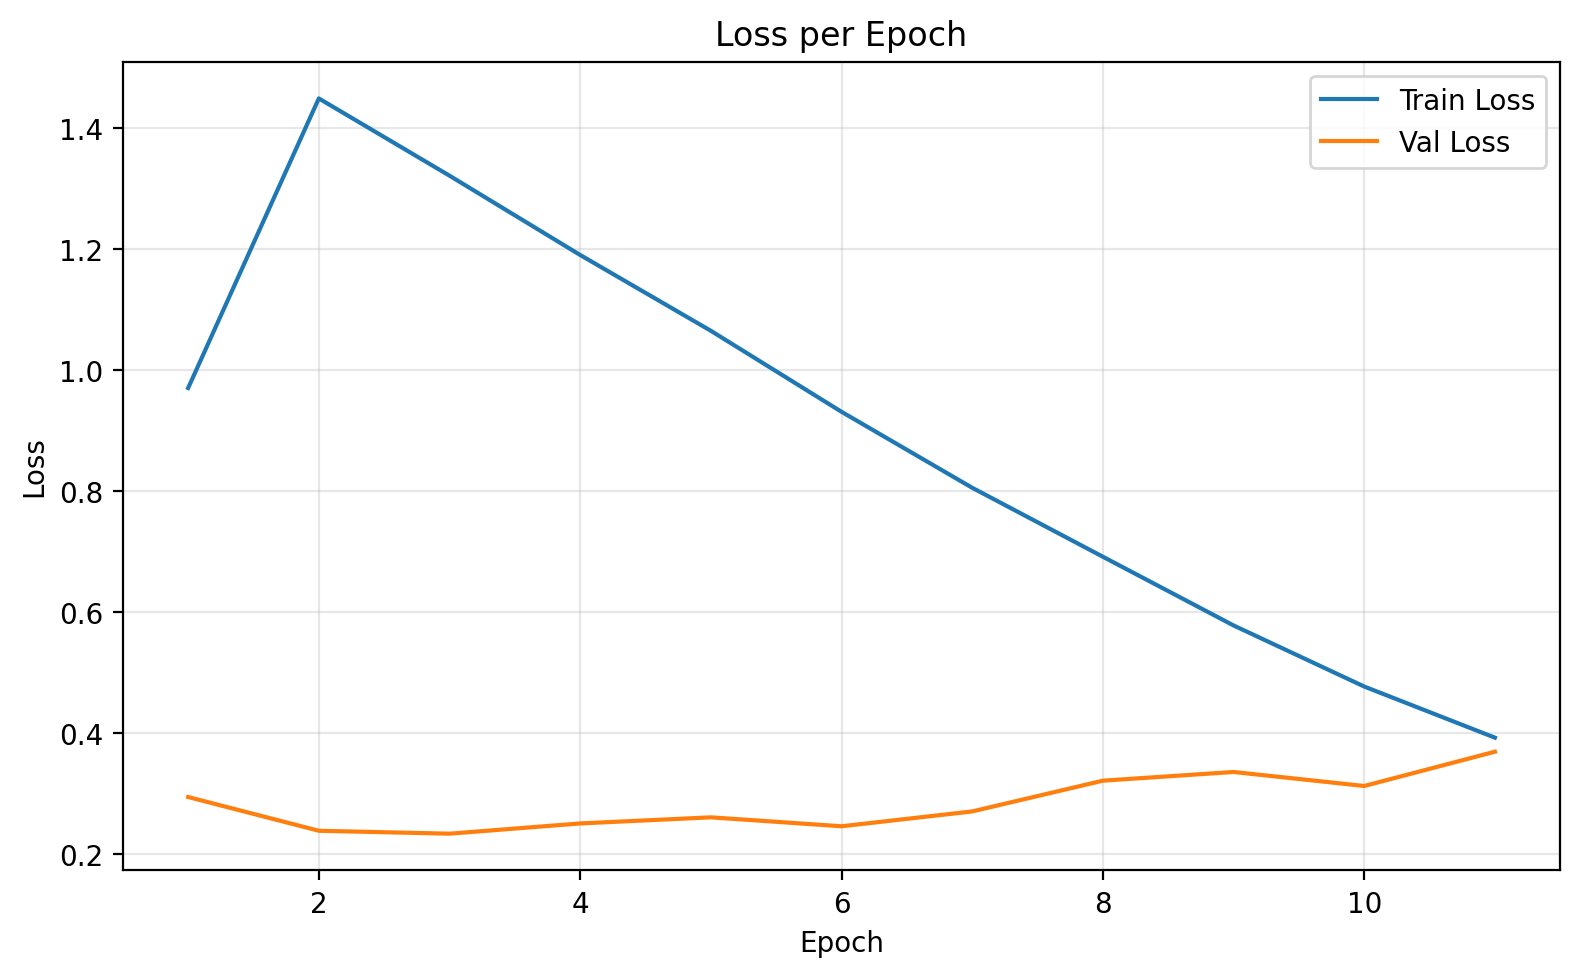

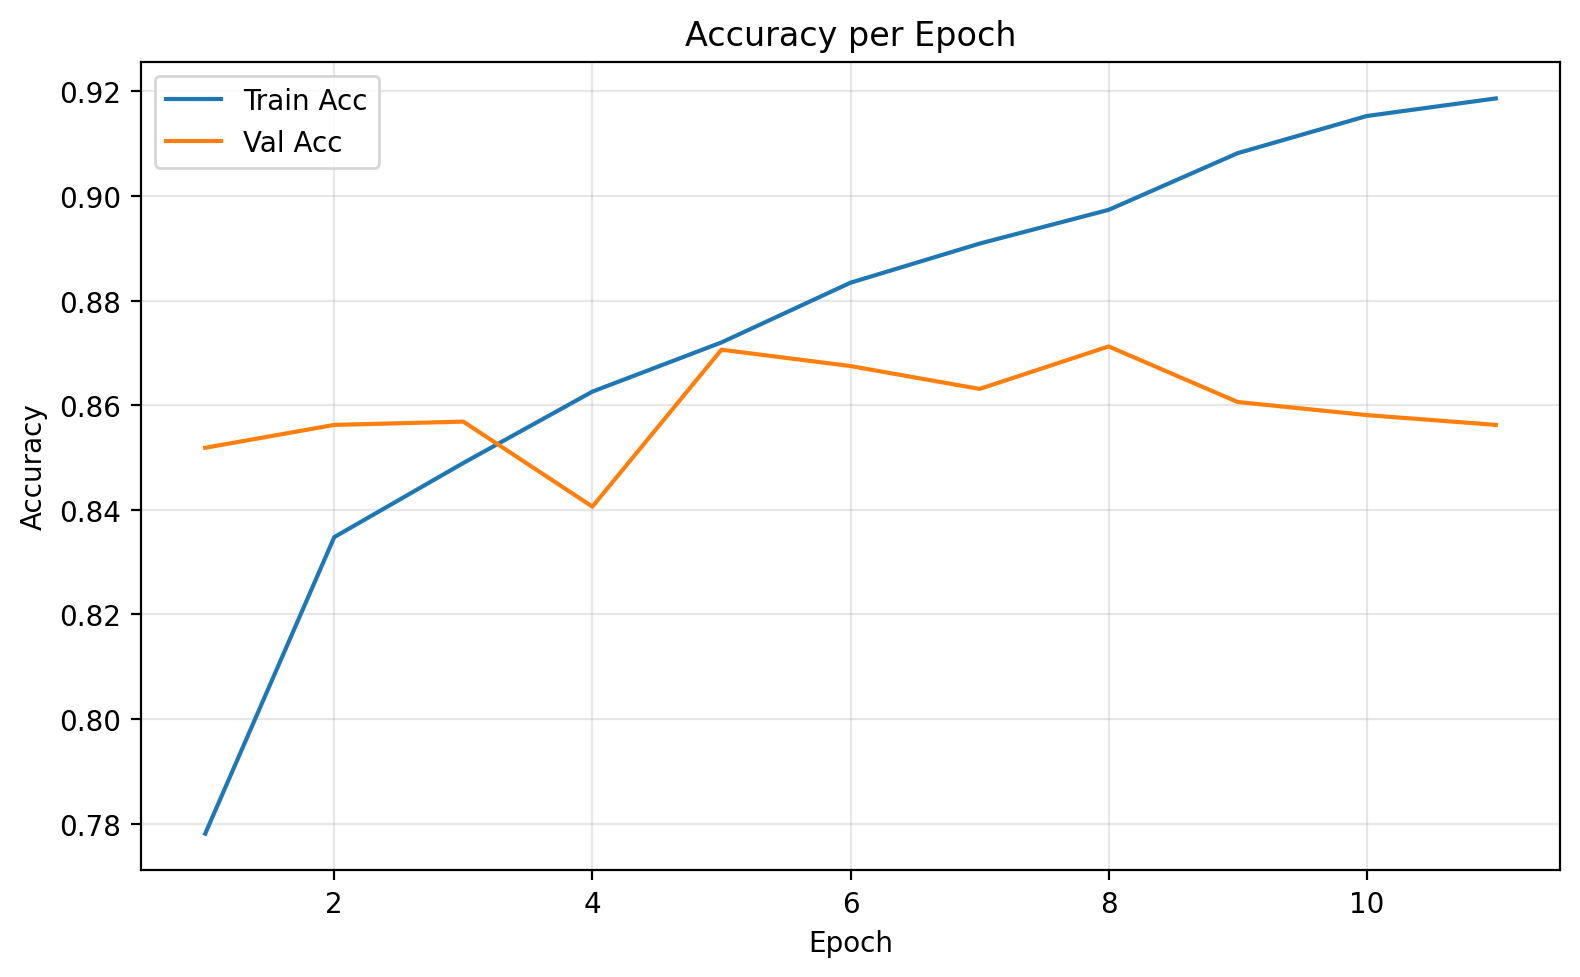

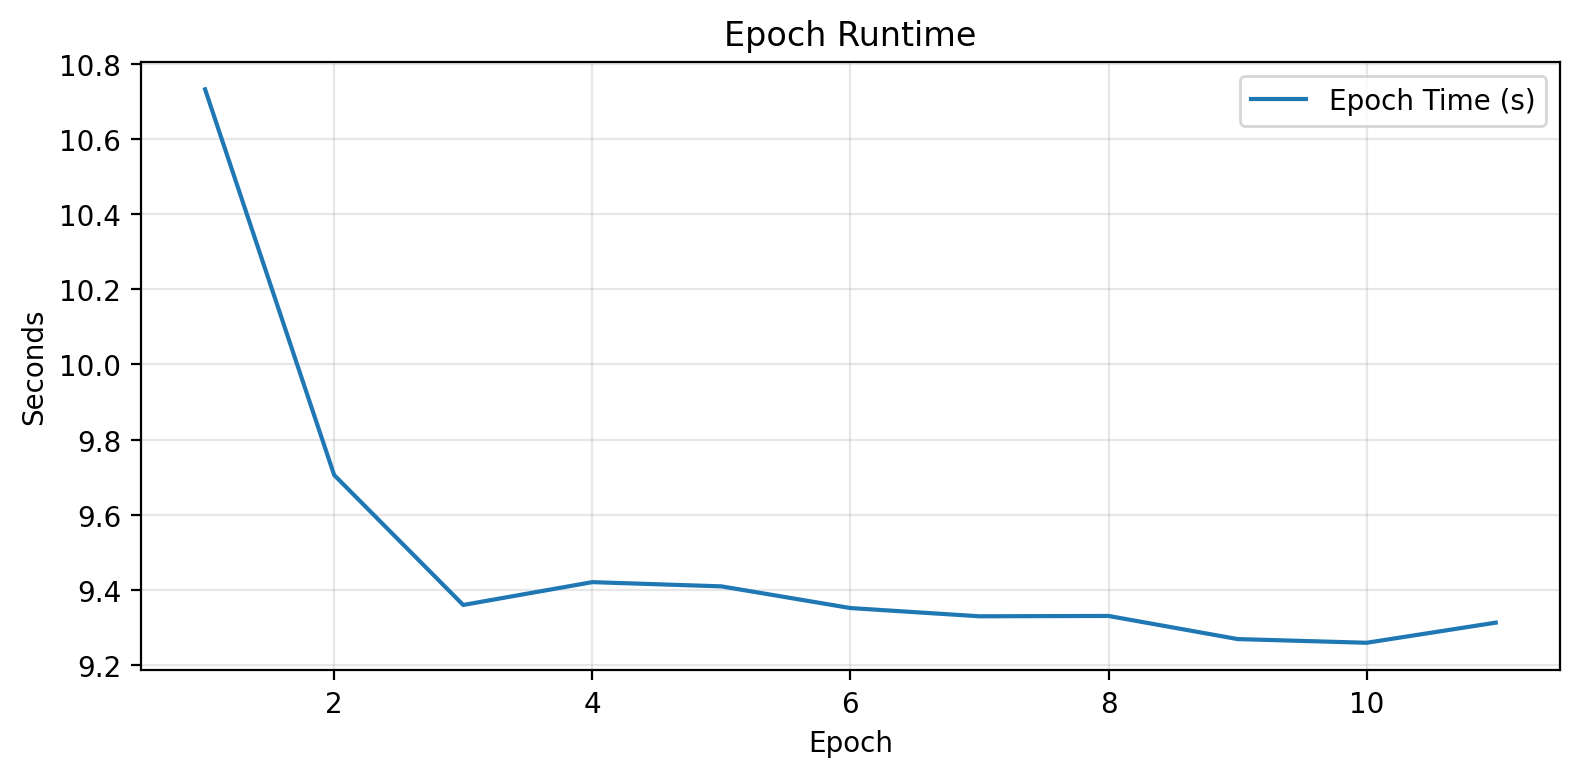

Best Val Acc: 0.8712 at epoch 8


In [ ]:
vocab_size = len(new_vocab_dict)+1 # +1 for the 0 padding
#embedding_dim = 300
# write codes to adjust embedding_dim to 768 when EMB_KIND is bert otherwise 300
if EMB_KIND == 'glove':
    embedding_dim = 300
elif EMB_KIND == 'word2vec':
    embedding_dim = 300
elif EMB_KIND == 'fasttext':
    embedding_dim = 300
elif EMB_KIND == 'bert':
    embedding_dim = 768

digits_dim = 1 # 1 lengths
pivot = 0.5
#hidden_dim = 300
# write the same codes to hidden_dim as above embedding_dim
if EMB_KIND == 'glove':
    hidden_dim = 300
elif EMB_KIND == 'word2vec':
    hidden_dim = 300
elif EMB_KIND == 'fasttext':
    hidden_dim = 300
elif EMB_KIND == 'bert':
    hidden_dim = 768

n_layers = 2 #no use
# num_heads = 10
#num_heads = 12
# write codes to update num_heads to 12 when EMB_KIND is bert otherwise 10
if EMB_KIND == 'glove':
    num_heads = 10
elif EMB_KIND == 'word2vec':
    num_heads = 10
elif EMB_KIND == 'fasttext':
    num_heads = 10
elif EMB_KIND == 'bert':
    num_heads = 12
#seed = 102003 #0.05
#seed = 102002 #0.09 5.05 pivot
#best seed = 42 0.51
#best seed = 42 p1*0.05 0007% organic
seed = 42 #0.92
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# intialization with the desired archtecture for GPU
use_cuda = torch.cuda.is_available()
print(use_cuda)

device = torch.device('cuda' if use_cuda else 'cpu')

train_on_gpu = use_cuda

## Time Module
# =============================================================================
import time, datetime, os
from contextlib import contextmanager

def _sync():
    if torch.cuda.is_available():
        torch.cuda.synchronize()

@contextmanager
def timer(name: str):
    _sync()
    t0 = time.perf_counter()
    try:
        yield
    finally:
        _sync()
        dt = time.perf_counter() - t0
        print(f"[TIMER] {name}: {dt:.3f}s ({dt/60:.2f} min)")

## Train
# =============================================================================
# =========================
# 1) Imports
# =========================
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import itertools as it

if EMB_KIND == 'glove':
  S = 300
elif EMB_KIND == 'word2vec':
  S = 300
elif EMB_KIND == 'fasttext':
  S = 300
elif EMB_KIND == 'bert':
  S = 768


# ==== put this near other config flags ====
USE_RATING_AS_FEATURE = False  # set True to feed rating to the head (see below)

# Optional: if using rating as feature, we add it alongside 'digits' (length).
# That means digits_dim should be 2 (length + rating_norm).
if USE_RATING_AS_FEATURE:
    digits_dim = 2  # length + rating
else:
    digits_dim = 1  # length only (your current setup)

# ---- helper to unpack batches that may include ratings ----
def unpack_batch(batch):
    # supports (inputs, labels) or (inputs, labels, ratings)
    if isinstance(batch, (tuple, list)) and len(batch) == 3:
        x, y, r = batch
    else:
        x, y = batch
        r = None
    return x, y, r


# =========================
# 3) Instantiate your blocks (keep your existing classes)
# =========================
mb0 = Embeds(vocab_size, pad_embedding_matrix, hidden_dim)  # make sure your embeddings are trainable if you want
mb1 = Sentiment_block(vocab_size, pad_embedding_matrix, hidden_dim, n_layers,
                      max_relative_position=2, pivot=pivot, num_heads=num_heads, reduced_dim=S)
mb2 = Mask_block(vocab_size, pad_embedding_matrix, hidden_dim, n_layers,
                 max_relative_position=2, pivot=pivot, num_heads=num_heads, reduced_dim=S)

# NEW vector Bayesian head
mb3 = SynthesizerVIvec(feature_dim=S, digits_dim=digits_dim, prior_sigma=1.0, dropout_p=0.2)

# =========================
# 4) Training setup
# =========================
from torch.optim.lr_scheduler import CosineAnnealingLR

lr1 = 1e-3   # Sentiment_block (was 5e-4)
lr2 = 1e-3   # Mask_block
lr3 = 7e-4   # Bayesian head (keep a bit lower)
lr0 = 3e-5   # Embeds (smaller to avoid forgetting)

# put near config
LAMBDA1 = 0.002   # (was 0.01)
LAMBDA3 = 0.005   # (was 0.02) on sqrt term

ss, ga = 2, 0.65
train_on_gpu = True
use_mask = True
epochs = 20
clip = 5


criterion = nn.BCEWithLogitsLoss()  # logits-based loss (stable)

optimizer1 = torch.optim.AdamW(mb1.parameters(), lr=lr1, eps=1e-8, weight_decay=1e-4)
optimizer2 = torch.optim.AdamW(mb2.parameters(), lr=lr2, eps=1e-8, weight_decay=1e-4)
optimizer3 = torch.optim.AdamW(mb3.parameters(), lr=lr3, eps=1e-8, weight_decay=1e-4)
optimizer0 = torch.optim.AdamW(mb0.parameters(), lr=lr0, eps=1e-8, weight_decay=1e-5)

scheduler1 = CosineAnnealingLR(optimizer1, T_max=epochs, eta_min=lr1*0.01)
scheduler2 = CosineAnnealingLR(optimizer2, T_max=epochs, eta_min=lr2*0.01)
scheduler3 = CosineAnnealingLR(optimizer3, T_max=epochs, eta_min=lr3*0.01)
scheduler0 = CosineAnnealingLR(optimizer0, T_max=epochs, eta_min=lr0*0.1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mb0.to(device); mb1.to(device); mb2.to(device); mb3.to(device); criterion.to(device)

# =========================
# (modified) compute pos_weight from training data
# =========================
with torch.no_grad():
    pos, neg = 0, 0
    for batch in train_loader:
        xb, yb, _ = unpack_batch(batch)
        pos += int((yb == 1).sum().item())
        neg += int((yb == 0).sum().item())
if pos > 0 and neg > 0:
    pos_weight = torch.tensor([neg / max(1, pos)], device=device, dtype=torch.float)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# =========================
# 5) Train / Validate
# =========================
def masked_mean_token_vector(token_feats, pad_mask):
    """
    token_feats: [B, T, S] from Sentiment_block (use its 'save_out')
    pad_mask:    [B, T] True for real tokens (from mb0)
    returns:     [B, S]
    """
    m = pad_mask.float()
    num = (token_feats * m.unsqueeze(-1)).sum(dim=1)                      # [B,S]
    den = m.sum(dim=1).clamp_min(1.0).unsqueeze(-1)                       # [B,1]
    return num / den

# --- add near imports ---
import time

def _sync():
    if torch.cuda.is_available():
        torch.cuda.synchronize()

# --- metric storage you asked for ---
all_epoch_train_loss, all_epoch_val_loss = [], []
all_epoch_train_acc,  all_epoch_val_acc = [], []   # (added this for train acc)
counter = 0
epoch_times = []
run_t0 = time.perf_counter()

print_every = 100  # adjust as you like
n_batches = len(train_loader)

best_state = None
best_val = -1
patience, bad = 3, 0

# =========================
# 5) Train / Validate
# =========================
for e in range(epochs):
    #scheduler0.step(); scheduler1.step(); scheduler2.step(); scheduler3.step()

    #progress = min(1.0, (e+1)/2.0)
    #beta = progress * (1.0 / n_batches)

    C_BETA = 1.5  # try 1.5–3.0
    progress = min(1.0, (e+1)/2.0)
    beta = C_BETA * progress * (1.0 / n_batches)

    _sync(); t0 = time.perf_counter()

    # ---- TRAIN ----
    mb0.train(); mb1.train(); mb2.train(); mb3.train()
    train_loss_sum = 0.0
    train_correct  = 0
    train_total    = 0

    for step, batch in enumerate(train_loader, 1):
        inputs, labels, ratings = unpack_batch(batch)

        inputs = inputs.to(device).long()
        labels = labels.to(device).float()
        if ratings is not None:
            ratings = ratings.to(device)  # int32; keep if you want to log/use

        optimizer0.zero_grad(); optimizer1.zero_grad()
        optimizer2.zero_grad(); optimizer3.zero_grad()
        scheduler0.step(); scheduler1.step();
        scheduler2.step(); scheduler3.step()

        # split fields
        texts  = inputs[:, :pad_size]
        digits = inputs[:, pad_size:(pad_size + 1)]  # current 'length' column
        digits_use = digits  # shape [B,1] for length

        # (optional) append normalized rating as an extra feature to the head
        if USE_RATING_AS_FEATURE and ratings is not None:
            # normalize rating 80..100 -> 0..1 (or (r-80)/20)
            rating_norm = (ratings.float() - 80.0) / 20.0
            rating_norm = rating_norm.clamp(0.0, 1.0).unsqueeze(1)  # [B,1]
            digits_use  = torch.cat([digits_use.float(), rating_norm], dim=1)  # [B,2]

        # forward through encoder
        embeds, mask_1 = mb0(texts)
        mask_out, p1, p3, mean_mask    = mb2(embeds, mask_1, digits)
        sent_out, token_feats, _       = mb1(embeds, mask_1, mask_out, digits)   # [B,T,S]

        # masked mean vector [B,S]  (pad mask; or swap to mask_out if desired)
        m = mask_1.float()
        h_vec = (token_feats * m.unsqueeze(-1)).sum(1) / m.sum(1).clamp_min(1.0).unsqueeze(-1)

        # Bayesian head (sample=True for VI training)
        probs, logits = mb3(h_vec, digits=digits_use if digits_dim > 0 else None, sample=True)

        # ELBO loss (+ your mask penalties)
        nll  = criterion(logits, labels)
        kl   = mb3.kl()
        loss = nll + beta*kl + torch.mean(p1 * LAMBDA1) + torch.mean((p3+1e-8).pow(0.5) * LAMBDA3)

        loss.backward()

        nn.utils.clip_grad_norm_(
            list(mb0.parameters())+list(mb1.parameters())+list(mb2.parameters())+list(mb3.parameters()),
            max_norm=5.0
        )

        optimizer0.step(); optimizer1.step(); optimizer2.step(); optimizer3.step()

        train_loss_sum += float(loss.item())
        with torch.no_grad():
            preds = (torch.sigmoid(logits) >= 0.5).long()
            train_correct += int((preds == labels.long()).sum().item())
            train_total   += int(labels.numel())

        if step % print_every == 0:
            print(f"Epoch {e+1}/{epochs} | Step {step}/{n_batches} | "
                  f"TrainLoss(avg so far) {train_loss_sum/step:.4f} | "
                  f"NLL {nll.item():.4f} | KL {kl.item():.4f} | beta {beta:.5f}")

    train_loss_mean = train_loss_sum / max(1, n_batches)
    train_acc       = train_correct / max(1, train_total)

    # ---- VALIDATE ----
    mb0.eval(); mb1.eval(); mb2.eval(); mb3.eval()
    val_losses = []
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for batch in valid_loader:
            vinputs, vlabels, vratings = unpack_batch(batch)

            vinputs = vinputs.to(device).long()
            vlabels = vlabels.to(device).float()
            if vratings is not None:
                vratings = vratings.to(device)

            vtexts  = vinputs[:, :pad_size]
            vdigits = vinputs[:, pad_size:(pad_size + 1)]
            vdigits_use = vdigits

            if USE_RATING_AS_FEATURE and vratings is not None:
                vrat_norm = (vratings.float() - 80.0) / 20.0
                vrat_norm = vrat_norm.clamp(0.0, 1.0).unsqueeze(1)
                vdigits_use = torch.cat([vdigits_use.float(), vrat_norm], dim=1)

            vembeds, vmask_1 = mb0(vtexts)
            vmask_out, vp1, vp3, vmean_mask = mb2(vembeds, vmask_1, vdigits)
            vsent_out, vtoken_feats, _      = mb1(vembeds, vmask_1, vmask_out, vdigits)

            vm = vmask_1.float()
            vh_vec = (vtoken_feats * vm.unsqueeze(-1)).sum(1) / vm.sum(1).clamp_min(1.0).unsqueeze(-1)

            vprobs, vlogits = mb3(vh_vec, digits=vdigits_use if digits_dim > 0 else None, sample=False)

            vloss = criterion(vlogits, vlabels)
            val_losses.append(vloss.item())

            vpreds = (torch.sigmoid(vlogits) >= 0.5).long()
            val_correct += int((vpreds == vlabels.long()).sum().item())
            val_total   += int(vlabels.numel())

    val_loss_mean = float(np.mean(val_losses)) if len(val_losses) else 0.0
    val_acc       = val_correct / max(1, val_total)

    _sync()
    dt = time.perf_counter() - t0
    epoch_times.append(dt)

    all_epoch_train_loss.append(train_loss_mean)
    all_epoch_val_loss.append(val_loss_mean)
    all_epoch_train_acc.append(train_acc)
    all_epoch_val_acc.append(val_acc)

    total_elapsed = time.perf_counter() - run_t0
    print(f"[EPOCH {e+1}/{epochs}] "
          f"TrainLoss {train_loss_mean:.4f} | TrainAcc {train_acc:.4f} | "
          f"ValLoss {val_loss_mean:.4f} | ValAcc {val_acc:.4f} | "
          f"EpochTime {dt:.2f}s | Total {total_elapsed/60:.2f} min")

    # at end of epoch:
    if val_acc > best_val:
        best_val = val_acc
        best_state = {
            "mb0": mb0.state_dict(), "mb1": mb1.state_dict(),
            "mb2": mb2.state_dict(), "mb3": mb3.state_dict(),
        }
        bad = 0
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break

print(f"Best Val Acc: {best_val:.4f}")
print(f"Avg epoch time: {np.mean(epoch_times):.2f}s  |  Total time: {sum(epoch_times):.2f}s")

# after training:
if best_state is not None:
    mb0.load_state_dict(best_state["mb0"]); mb1.load_state_dict(best_state["mb1"])
    mb2.load_state_dict(best_state["mb2"]); mb3.load_state_dict(best_state["mb3"])

## Plot the training and validation accuracy against epoch, and Plot the training and validation loss function aginast epoch
# =============================================================================
# === Plot Training vs Validation: Loss & Accuracy, plus Epoch Time ===
import numpy as np
import matplotlib.pyplot as plt

# Make sure we have the same number of points for all series we’ll plot
def _min_len(*seqs):
    return min(len(s) for s in seqs if s is not None)

E_loss = _min_len(all_epoch_train_loss, all_epoch_val_loss)
E_acc  = _min_len(all_epoch_train_acc,  all_epoch_val_acc) if 'all_epoch_train_acc' in globals() else 0
E_time = len(epoch_times) if 'epoch_times' in globals() else 0

# X-axes
x_loss = np.arange(1, E_loss+1)
x_acc  = np.arange(1, E_acc+1)
x_time = np.arange(1, E_time+1)

# --- 1) Loss plot ---
plt.figure(figsize=(8, 5))
plt.plot(x_loss, all_epoch_train_loss[:E_loss], label='Train Loss')
plt.plot(x_loss, all_epoch_val_loss[:E_loss],   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss per Epoch')
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
plt.show()

# --- 2) Accuracy plot ---
if E_acc > 0:
    plt.figure(figsize=(8, 5))
    plt.plot(x_acc, all_epoch_train_acc[:E_acc], label='Train Acc')
    plt.plot(x_acc, all_epoch_val_acc[:E_acc],   label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy per Epoch')
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
    plt.show()

# --- 3) Epoch time plot (seconds) ---
if E_time > 0:
    plt.figure(figsize=(8, 4))
    plt.plot(x_time, epoch_times[:E_time], label='Epoch Time (s)')
    plt.xlabel('Epoch'); plt.ylabel('Seconds'); plt.title('Epoch Runtime')
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
    plt.show()

# Optional: print best metrics
if E_acc > 0:
    best_val_epoch = int(np.argmax(all_epoch_val_acc[:E_acc])) + 1
    print(f"Best Val Acc: {all_epoch_val_acc[best_val_epoch-1]:.4f} at epoch {best_val_epoch}")

# Evaluate the uncertainty level for Train/Dev/Test

In [ ]:
# =========================
# Evaluate with best threshold from VALIDATION
# =========================
import torch, numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss

device = next(mb3.parameters()).device
T = 100   # MC samples for uncertainty (adjust for speed/precision)

# Must match training!
USE_RATING_AS_FEATURE = False   # True if you trained with rating concatenated to digits

@torch.no_grad()
def _entropy(p, eps=1e-12):
    p = p.clamp(eps, 1-eps)
    return -(p*torch.log(p) + (1-p)*torch.log(1-p))

def _unpack_batch(batch):
    # supports (inputs, labels) or (inputs, labels, ratings)
    if isinstance(batch, (tuple, list)) and len(batch) == 3:
        x, y, r = batch
    else:
        x, y = batch
        r = None
    return x, y, r

@torch.no_grad()
def collect_predictions_with_uncertainty(loader, pad_size, digits_dim, T=100, device=None, threshold=0.5):
    """Returns a DataFrame with y_true, p_mean, ci95, var, entropy, bald, plus:
       prob1, prob0, label_by_mean, certain, support, and original 'rating'."""
    device = device or next(mb3.parameters()).device
    mb0.eval(); mb1.eval(); mb2.eval(); mb3.eval()

    rows = []
    for _, batch in enumerate(loader):
        inputs, labels, ratings = _unpack_batch(batch)

        inputs = inputs.to(device).long()
        labels = labels.to(device).float()
        if ratings is not None:
            ratings = ratings.to(device)  # int tensor

        # ---- split fields
        texts       = inputs[:, :pad_size]
        digits_len  = inputs[:, pad_size:(pad_size + 1)]        # the length feature stored in inputs
        digits_use  = digits_len                                # shape [B,1]

        # (optional) append normalized rating to the head inputs
        if USE_RATING_AS_FEATURE and (ratings is not None):
            rating_norm = (ratings.float() - 80.0) / 20.0       # 80..100 -> 0..1
            rating_norm = rating_norm.clamp(0.0, 1.0).unsqueeze(1)  # [B,1]
            digits_use  = torch.cat([digits_use.float(), rating_norm], dim=1)  # [B,2]

        # ---- encoder → token features
        embeds, mask_1 = mb0(texts)                         # [B,T,E], [B,T]
        mask_out, _, _, _ = mb2(embeds, mask_1, digits_len) # [B,T]
        _, token_feats, _ = mb1(embeds, mask_1, mask_out, digits_len)  # [B,T,S]

        # ---- masked-mean sentence vector [B,S] (pad mask; switch to mask_out if you prefer)
        m = mask_1.float()
        h_vec = (token_feats * m.unsqueeze(-1)).sum(1) / m.sum(1).clamp_min(1.0).unsqueeze(-1)

        # ---- MC samples over Bayesian head
        Ps = []
        for _ in range(T):
            p, _ = mb3(h_vec, digits=digits_use if digits_dim > 0 else None, sample=True)
            Ps.append(p)
        P = torch.stack(Ps, dim=0)                 # [T,B]

        # ---- summary stats
        mean_p  = P.mean(0)                         # [B]
        var_p   = P.var(0, unbiased=False)          # [B]
        lo95    = P.quantile(0.025, dim=0)          # [B]
        hi95    = P.quantile(0.975, dim=0)          # [B]
        H_mean  = _entropy(mean_p)                  # [B]
        H_each  = _entropy(P).mean(0)               # [B]
        bald    = H_mean - H_each                   # [B]

        # ---- posterior mass relative to threshold
        prob1 = (P >= threshold).float().mean(0)    # [B]
        prob0 = 1.0 - prob1                         # [B]

        # ---- decisions/flags
        label_by_mean = (mean_p >= threshold).long()                 # [B]
        certain = (lo95 >= threshold) | (hi95 <= threshold)          # [B]
        support = torch.maximum(prob1, prob0)                        # [B]

        B = inputs.size(0)
        for b in range(B):
            rows.append({
                "y_true": int(labels[b].item()),
                "rating": int(ratings[b].item()) if ratings is not None else None,  # <-- added
                "p_mean": float(mean_p[b].item()),
                "ci95_lo": float(lo95[b].item()),
                "ci95_hi": float(hi95[b].item()),
                "ci_width": float((hi95[b]-lo95[b]).item()),
                "var": float(var_p[b].item()),
                "entropy": float(H_mean[b].item()),
                "bald": float(bald[b].item()),
                "prob1": float(prob1[b].item()),
                "prob0": float(prob0[b].item()),
                "label_by_mean": int(label_by_mean[b].item()),
                "certain": bool(certain[b].item()),
                "support": float(support[b].item()),
                "threshold_used": float(threshold),
            })
    return pd.DataFrame(rows)

def choose_best_threshold_on_val(y_true, p_mean, metric="accuracy"):
    y = np.asarray(y_true).astype(int); p = np.asarray(p_mean)
    thrs = np.linspace(0.05, 0.95, 37)
    best_t, best = 0.5, -1
    for t in thrs:
        pred = (p >= t).astype(int)
        score = (pred == y).mean() if metric == "accuracy" else 0.0
        if score > best:
            best, best_t = score, float(t)
    return best_t, best

def compute_metrics(df, threshold):
    y = df["y_true"].to_numpy().astype(int)
    p = df["p_mean"].to_numpy()
    pred = (p >= threshold).astype(int)

    acc   = (pred == y).mean()
    auroc = roc_auc_score(y, p) if len(np.unique(y)) > 1 else float("nan")
    aupr  = average_precision_score(y, p) if len(np.unique(y)) > 1 else float("nan")
    brier = float(np.mean((p - y)**2))
    try:
        nll = float(log_loss(y, p, eps=1e-15))
    except Exception:
        nll = float("nan")

    # ECE (Expected Calibration Error)
    def ece(y_true, probs, n_bins=15):
        bins = np.linspace(0, 1, n_bins+1)
        idx  = np.digitize(probs, bins) - 1
        N = len(probs); e = 0.0
        for b in range(n_bins):
            m = (idx == b)
            n_b = m.sum()
            if n_b == 0: continue
            conf = probs[m].mean()
            accb = ((probs[m] >= 0.5).astype(int) == y_true[m]).mean()
            e += (n_b / N) * abs(accb - conf)
        return float(e)
    ece_val = ece(y, p)

    return {
        "threshold": float(threshold),
        "acc": float(acc),
        "auroc": float(auroc),
        "aupr": float(aupr),
        "brier": float(brier),
        "nll": float(nll),
        "ece": float(ece_val),
    }

# ---- 1) Collect VAL with default threshold (0.5 is fine) and pick best threshold on p_mean
val_df_for_thr = collect_predictions_with_uncertainty(valid_loader, pad_size, digits_dim, T=T, device=device, threshold=0.5)
best_thr, best_val_acc = choose_best_threshold_on_val(val_df_for_thr["y_true"], val_df_for_thr["p_mean"], metric="accuracy")
print(f"[VALID] Best threshold by accuracy: {best_thr:.3f} (val acc at that thr ≈ {best_val_acc:.4f})")

# ---- 2) Now recollect TRAIN / VALID / TEST with the chosen threshold so prob1/prob0/certain reflect it
train_df = collect_predictions_with_uncertainty(train_loader, pad_size, digits_dim, T=T, device=device, threshold=best_thr)
val_df   = collect_predictions_with_uncertainty(valid_loader, pad_size, digits_dim, T=T, device=device, threshold=best_thr)
test_df  = collect_predictions_with_uncertainty(test_loader,  pad_size, digits_dim, T=T, device=device, threshold=best_thr)

# ---- 3) Metrics still use p_mean + best_thr
train_metrics = compute_metrics(train_df, best_thr)
val_metrics   = compute_metrics(val_df,   best_thr)
test_metrics  = compute_metrics(test_df,  best_thr)

print("\n[TRAIN metrics]", train_metrics)
print("[VALID metrics]", val_metrics)
print("[TEST  metrics]", test_metrics)

# save detailed per-item predictions (now includes 'rating')
# common save path
cpath = "./classification notebook/uncertainty/Twitter/"
train_df.to_csv(cpath + "train_predictions_with_uncertainty.csv", index=False)
val_df.to_csv(cpath + "val_predictions_with_uncertainty.csv", index=False)
test_df.to_csv(cpath + "test_predictions_with_uncertainty.csv", index=False)
print("\nSaved: train/val/test_predictions_with_uncertainty.csv")


# Display the first few rows of each predictions DataFrame
import pandas as pd
from IPython.display import display

pd.set_option("display.max_colwidth", 160)  # make long text columns easier to read

def show_heads(n=5):
    for name, df in [("train_df", train_df), ("val_df", val_df), ("test_df", test_df)]:
        print(f"\n{name} (first {n} rows)")
        try:
            display(df.head(n))
        except NameError:
            print(f"{name} is not defined. Run the evaluation cell that creates it first.")

# change n if you want more/less rows
show_heads(n=10)

[VALID] Best threshold by accuracy: 0.375 (val acc at that thr ≈ 0.8688)

[TRAIN metrics] {'threshold': 0.37499999999999994, 'acc': 0.9232642700329309, 'auroc': 0.9774814576503499, 'aupr': 0.98812230542077, 'brier': 0.05601753546781079, 'nll': nan, 'ece': 0.289556635109436}
[VALID metrics] {'threshold': 0.37499999999999994, 'acc': 0.868125, 'auroc': 0.9170277696140413, 'aupr': 0.9452776024612596, 'brier': 0.10974861632347033, 'nll': nan, 'ece': 0.2915947507030012}
[TEST  metrics] {'threshold': 0.37499999999999994, 'acc': 0.865, 'auroc': 0.9238753974844551, 'aupr': 0.9502341243159953, 'brier': 0.10595243362797949, 'nll': nan, 'ece': 0.2923699389142125}

Saved: train/val/test_predictions_with_uncertainty.csv

train_df (first 10 rows)


,y_true,rating,p_mean,ci95_lo,ci95_hi,ci_width,var,entropy,bald,prob1,prob0,label_by_mean,certain,support,threshold_used
0,1,0,0.988548,0.938168,0.999414,0.061246,2.614854e-04,0.062572,0.007472,1.0,0.0,1,True,1.0,0.375
1,1,0,0.999962,0.999698,1.000000,0.000302,3.342826e-08,0.000425,NaN,1.0,0.0,1,True,1.0,0.375
2,1,0,0.933708,0.800655,0.984952,0.184296,1.937637e-03,0.243941,0.013943,1.0,0.0,1,True,1.0,0.375
3,0,0,0.007598,0.000149,0.048030,0.047881,1.849836e-04,0.044645,0.006793,0.0,1.0,0,True,1.0,0.375
4,1,0,0.981156,0.896299,0.998769,0.102471,5.569351e-04,0.093504,0.010408,1.0,0.0,1,True,1.0,0.375
5,1,0,0.985735,0.928661,0.999135,0.070475,3.434833e-04,0.074790,0.008297,1.0,0.0,1,True,1.0,0.375
6,1,0,0.996478,0.973876,0.999958,0.026082,5.271803e-05,0.023411,0.003764,1.0,0.0,1,True,1.0,0.375
7,1,0,0.753809,0.579456,0.871877,0.292421,6.198904e-03,0.558112,0.016488,1.0,0.0,1,True,1.0,0.375
8,1,0,0.998709,0.989467,0.999995,0.010529,1.203668e-05,0.009878,0.001889,1.0,0.0,1,True,1.0,0.375
9,1,0,0.997365,0.980525,0.999976,0.019452,3.470126e-05,0.018281,0.003106,1.0,0.0,1,True,1.0,0.375



val_df (first 10 rows)


,y_true,rating,p_mean,ci95_lo,ci95_hi,ci_width,var,entropy,bald,prob1,prob0,label_by_mean,certain,support,threshold_used
0,1,0,0.996942,0.989778,1.000000,0.010222,0.000525,0.020761,NaN,1.00,0.00,1,True,1.00,0.375
1,1,0,0.416436,0.179989,0.653923,0.473934,0.018032,0.679116,0.038379,0.55,0.45,1,False,0.55,0.375
2,1,0,0.994577,0.968461,0.999999,0.031538,0.000932,0.033702,0.015248,1.00,0.00,1,True,1.00,0.375
3,1,0,0.971707,0.855579,0.999183,0.143604,0.003268,0.128756,0.028703,1.00,0.00,1,True,1.00,0.375
4,0,0,0.417534,0.238476,0.597727,0.359251,0.009028,0.679484,0.018922,0.64,0.36,1,False,0.64,0.375
5,1,0,0.961029,0.825496,0.998117,0.172621,0.004028,0.164662,0.030856,1.00,0.00,1,True,1.00,0.375
6,1,0,0.710182,0.389287,0.896831,0.507544,0.018381,0.601988,0.044177,0.98,0.02,1,True,0.98,0.375
7,1,0,0.992569,0.950755,0.999991,0.049236,0.001116,0.043832,0.017105,1.00,0.00,1,True,1.00,0.375
8,1,0,0.985865,0.901337,0.999887,0.098550,0.001873,0.074235,0.022246,1.00,0.00,1,True,1.00,0.375
9,1,0,0.963777,0.813149,0.997940,0.184791,0.003166,0.155750,0.026424,1.00,0.00,1,True,1.00,0.375



test_df (first 10 rows)


,y_true,rating,p_mean,ci95_lo,ci95_hi,ci_width,var,entropy,bald,prob1,prob0,label_by_mean,certain,support,threshold_used
0,1,0,0.046593,0.005834,0.160508,0.154674,0.001997,0.188358,0.018225,0.00,1.00,0,True,1.00,0.375
1,1,0,0.993182,0.966630,0.999896,0.033266,0.000340,0.040802,0.008541,1.00,0.00,1,True,1.00,0.375
2,1,0,0.999381,0.998633,1.000000,0.001367,0.000025,0.005194,NaN,1.00,0.00,1,True,1.00,0.375
3,1,0,0.978491,0.914361,0.998770,0.084408,0.001265,0.103855,0.016274,1.00,0.00,1,True,1.00,0.375
4,1,0,0.928512,0.782129,0.986485,0.204356,0.003931,0.257470,0.023985,1.00,0.00,1,True,1.00,0.375
5,0,0,0.016456,0.000892,0.073021,0.072129,0.000583,0.083905,0.011009,0.00,1.00,0,True,1.00,0.375
6,1,0,0.864172,0.700926,0.951815,0.250889,0.005235,0.397318,0.020700,1.00,0.00,1,True,1.00,0.375
7,1,0,0.116681,0.011773,0.381133,0.369360,0.011607,0.360259,0.048210,0.03,0.97,0,False,0.97,0.375
8,1,0,0.128866,0.043711,0.261692,0.217981,0.004210,0.384226,0.018167,0.01,0.99,0,True,0.99,0.375
9,1,0,0.998188,0.992563,0.999998,0.007435,0.000103,0.013249,0.004527,1.00,0.00,1,True,1.00,0.375


# Define the functions to Evaluate Sentiment score for each token

In [ ]:
import torch, pandas as pd
from collections import defaultdict

@torch.no_grad()
def sentiment_block_top_words_unconditional_calibrated(
    loader,
    pad_size: int,
    id2word: dict,
    mb0, mb1, mb2,
    use_mask_kind: str = "pad",    # 'pad' or 'learned'
    top_k: int = 50,
    min_count_total: int = 20,
    rank_by: str = "mean_mu"       # 'mean_mu' or 'mean_p' (controls full_df order)
):
    device = next(mb1.parameters()).device
    mb0.eval(); mb1.eval(); mb2.eval()

    # -------- Pass 1: calibration to determine sign --------
    n_seen = 0
    sum_pos, cnt_pos = 0.0, 0
    sum_neg, cnt_neg = 0.0, 0
    for batch in loader:
        if isinstance(batch, (tuple, list)) and len(batch) == 3:
            inputs, y, _ = batch
        else:
            inputs, y = batch
        inputs = inputs.to(device).long()
        y = y.to(device).long()

        texts      = inputs[:, :pad_size]
        digits_len = inputs[:, pad_size:(pad_size+1)]

        embeds, mask_1   = mb0(texts)                         # [B,T,E], [B,T] bool
        mask_soft        = mb2(embeds, mask_1, digits_len)[0] # [B,T] float 0..1
        scores, _, _     = mb1(embeds, mask_1, mask_soft, digits_len)

        m = (mask_soft >= 0.001) if (use_mask_kind == "learned") else mask_1
        B, T = texts.shape
        y_bt = y.view(B,1).expand(B,T)

        pos_scores = scores[m & (y_bt==1)]
        neg_scores = scores[m & (y_bt==0)]
        if pos_scores.numel() > 0:
            sum_pos += pos_scores.mean().item() * pos_scores.numel()
            cnt_pos += pos_scores.numel()
        if neg_scores.numel() > 0:
            sum_neg += neg_scores.mean().item() * neg_scores.numel()
            cnt_neg += neg_scores.numel()

        n_seen += 1
        if n_seen >= 5:
            break

    mean_pos = (sum_pos / max(1, cnt_pos)) if cnt_pos > 0 else 0.0
    mean_neg = (sum_neg / max(1, cnt_neg)) if cnt_neg > 0 else 0.0
    sign = 1.0 if (mean_pos >= mean_neg) else -1.0
    if sign < 0:
        print("[calibration] Detected inverted polarity in Sentiment_block scores; flipping sign.")

    # -------- Pass 2: aggregate unconditional stats --------
    sum_mu_all = defaultdict(float)
    sum_p_all  = defaultdict(float)
    cnt_all    = defaultdict(int)
    cnt_pos_tok= defaultdict(int)
    cnt_neg_tok= defaultdict(int)
    docs_pos   = defaultdict(int)
    docs_neg   = defaultdict(int)

    total_kept = 0

    for batch in loader:
        if isinstance(batch, (tuple, list)) and len(batch) == 3:
            inputs, y, _ = batch
        else:
            inputs, y = batch
        inputs = inputs.to(device).long()
        y = y.to(device).long()

        texts      = inputs[:, :pad_size]
        digits_len = inputs[:, pad_size:(pad_size+1)]

        embeds, mask_1   = mb0(texts)
        mask_soft        = mb2(embeds, mask_1, digits_len)[0]
        scores, _, _     = mb1(embeds, mask_1, mask_soft, digits_len)
        scores = sign * scores
        probs  = torch.sigmoid(scores)

        m = (mask_soft >= 0.001) if (use_mask_kind == "learned") else mask_1
        m_f = m.float()

        B, T = texts.shape
        ids     = texts.reshape(-1)
        valid   = (m_f.reshape(-1) > 0.5)
        mu_flat = scores.reshape(-1)[valid]
        p_flat  = probs.reshape(-1)[valid]
        ids_keep= ids[valid].tolist()
        y_bt    = y.view(B,1).expand(B,T).reshape(-1)[valid].tolist()

        total_kept += len(ids_keep)

        for wid, mu_v, p_v, yy in zip(ids_keep, mu_flat.tolist(), p_flat.tolist(), y_bt):
            wid = int(wid)
            if wid == 0:
                continue
            w = id2word.get(wid, None)
            if not w:
                continue
            sum_mu_all[w] += float(mu_v)
            sum_p_all[w]  += float(p_v)
            cnt_all[w]    += 1
            if int(yy) == 1:
                cnt_pos_tok[w] += 1
            else:
                cnt_neg_tok[w] += 1

        # doc-level support
        toks_cpu = texts.detach().cpu()
        mask_cpu = m.detach().cpu()
        y_cpu    = y.detach().cpu()
        for b in range(B):
            valid_ids = toks_cpu[b][mask_cpu[b] > 0.5].tolist()
            uniq_wids = {int(t) for t in valid_ids if t != 0 and id2word.get(int(t), None)}
            uniq_words = {id2word[t] for t in uniq_wids}
            if int(y_cpu[b].item()) == 1:
                for w in uniq_words: docs_pos[w] += 1
            else:
                for w in uniq_words: docs_neg[w] += 1

    # -------- Build table --------
    rows = []
    for w, ctot in cnt_all.items():
        if ctot < min_count_total:
            continue
        mean_mu = sum_mu_all[w] / ctot
        mean_p  = sum_p_all[w]  / ctot
        dpos, dneg = docs_pos[w], docs_neg[w]
        dtot = max(1, dpos + dneg)
        rows.append({
            "word": w,
            "count": ctot,
            "count_pos": cnt_pos_tok[w],
            "count_neg": cnt_neg_tok[w],
            "pos_docs": dpos,
            "neg_docs": dneg,
            "pos_prop_docs": dpos / dtot,
            "neg_prop_docs": dneg / dtot,
            "mean_mu": mean_mu,
            "mean_p":  mean_p
        })

    df = pd.DataFrame(rows)
    if df.empty:
        print("No words met the min_count_total threshold — try lowering it.")
        return df, df, df

    # full_df for reference
    key = "mean_mu" if rank_by == "mean_mu" else "mean_p"
    full_df = df.sort_values(key, ascending=False).reset_index(drop=True)

    # ===== Two-step TOP LISTS with within-word class proportion, normalized across K =====
    eps = 1e-8

    # Step 1: candidates by raw mean_mu
    cand_pos = df.sort_values("mean_mu", ascending=False).head(top_k).copy()
    cand_neg = df.sort_values("mean_mu", ascending=True ).head(top_k).copy()

    # Step 2: class proportion per word, then normalize so weights sum to 1 in each list
    # Positive: p_i = count_pos / (count_pos + count_neg)
    denom_pos = cand_pos["count_pos"] + cand_pos["count_neg"] + eps
    cand_pos["raw_w"] = cand_pos["count_pos"] / denom_pos
    sum_raw_pos = float(cand_pos["raw_w"].sum())
    cand_pos["w_norm"] = (cand_pos["raw_w"] / sum_raw_pos) if sum_raw_pos > 0 else (1.0 / max(1, len(cand_pos)))

    # Negative: p_i = count_neg / (count_pos + count_neg)
    denom_neg = cand_neg["count_pos"] + cand_neg["count_neg"] + eps
    cand_neg["raw_w"] = cand_neg["count_neg"] / denom_neg
    sum_raw_neg = float(cand_neg["raw_w"].sum())
    cand_neg["w_norm"] = (cand_neg["raw_w"] / sum_raw_neg) if sum_raw_neg > 0 else (1.0 / max(1, len(cand_neg)))

    # Final score = mean_mu * normalized weight
    cand_pos["w2_mean_mu"] = cand_pos["mean_mu"] * cand_pos["w_norm"]
    cand_neg["w2_mean_mu"] = cand_neg["mean_mu"] * cand_neg["w_norm"]

    top_pos = cand_pos.sort_values("w2_mean_mu", ascending=False).reset_index(drop=True)
    top_neg = cand_neg.sort_values("w2_mean_mu", ascending=True ).reset_index(drop=True)

    show_cols = ["word","count","count_pos","count_neg",
                 "pos_docs","neg_docs","pos_prop_docs","neg_prop_docs",
                 "mean_mu","raw_w","w_norm","w2_mean_mu","mean_p"]

    print(f"[diagnostics] total valid tokens aggregated: {total_kept:,}")
    return full_df, top_pos[show_cols], top_neg[show_cols]

# Evaluate top words

In [ ]:
full_df, top_pos, top_neg = sentiment_block_top_words_unconditional_calibrated(
    loader=train_loader,
    pad_size=pad_size,
    id2word=new_vocab_id2word,
    mb0=mb0, mb1=mb1, mb2=mb2,
    use_mask_kind="pad",      # start with 'pad'; switch to 'learned' if your mask is reliable
    top_k=50,
    min_count_total=50,
    rank_by="mean_mu"         # or "mean_p"
)

print("\nTOP POSITIVE (unconditional, calibrated):")
print(top_pos.to_string(index=False))
print("\nTOP NEGATIVE (unconditional, calibrated):")
print(top_neg.to_string(index=False))

[diagnostics] total valid tokens aggregated: 554,980

TOP POSITIVE (unconditional, calibrated):
      word  count  count_pos  count_neg  pos_docs  neg_docs  pos_prop_docs  neg_prop_docs  mean_mu    raw_w   w_norm  w2_mean_mu   mean_p
      grin    172        164          8       157         8       0.951515       0.048485 0.595125 0.953488 0.020828    0.012395 0.641229
     cream    195        190          5       153         5       0.968354       0.031646 0.548340 0.974359 0.021284    0.011671 0.632537
     thank    270        255         15       253        14       0.947566       0.052434 0.563265 0.944444 0.020631    0.011620 0.634255
 minecraft     84         81          3        73         3       0.960526       0.039474 0.524040 0.964286 0.021064    0.011038 0.625617
     loved     94         88          6        88         6       0.936170       0.063830 0.532138 0.936170 0.020450    0.010882 0.628064
      wars    127        109         18       103        16       0.865546  

# Define functions for Query reviews and their sentiment given the word

In [ ]:
import torch, pandas as pd
from collections import defaultdict

@torch.no_grad()
def _unpack_batch_xy(batch):
    # supports (inputs, labels) or (inputs, labels, ratings)
    if isinstance(batch, (tuple, list)):
        return batch[0], batch[1]
    return batch

@torch.no_grad()
def find_reviews_with_words(
    loader,
    pad_size,
    id2word,
    query_words,                 # str or list[str]
    use_mask_kind='pad',         # 'pad' or 'learned'
    device=None,
    max_reviews_per_word=None,   # cap per word (None = no cap)
    return_token_scores=True,    # include per-token (token, score) list
    original_texts=None          # optional list[str] aligned to loader.dataset order
):
    """
    Search reviews that contain any of `query_words`. For each match, compute the
    Bayesian-head doc score (prob/logit), per-token contributions, and return
    context (reconstructed or original review text).

    Returns a pandas.DataFrame with columns:
      - word:               the matched query word
      - row_idx:            running row index across loader (1-based)
      - y_true:             gold label if available else None
      - prob, logit:        Bayesian head outputs for the review
      - n_tokens:           number of valid tokens (per chosen mask)
      - n_matches:          #occurrences of `word` among valid tokens
      - sum_match_contrib:  sum of contributions where token==word
      - token_contrib_sum:  sum of contributions over valid tokens
      - digits_contrib:     w_d · digits (if head used digits)
      - bias:               head bias term μ_b
      - recon_or_text:      reconstructed text (or original if provided)
      - tokens_scores:      [(token, contrib), ...] for valid tokens (optional)
    """
    # ====== setup / model handles ======
    device = device or next(mb3.parameters()).device
    mb0.eval(); mb1.eval(); mb2.eval(); mb3.eval()

    # normalize queries
    if isinstance(query_words, str):
        query_words = [query_words]
    query_words = [q.strip().lower() for q in query_words if str(q).strip()]

    # id-based fast match (case-insensitive)
    word2id = {w.lower(): i for i, w in id2word.items()}
    q_to_id = {q: word2id.get(q, None) for q in query_words}

    # head weights (posterior mean)
    w_mu_all = mb3.bayes_head.weight_mu[0].detach()    # shape [S + D]
    b_mu     = mb3.bayes_head.bias_mu[0].detach().item()

    rows = []
    global_row = 0
    kept_per_word = defaultdict(int)

    for batch in loader:
        x, y = _unpack_batch_xy(batch)
        x = x.to(device).long()
        y = y.to(device).long() if y is not None else None

        # split fields
        texts      = x[:, :pad_size]                 # [B,T]
        digits_len = x[:, pad_size:(pad_size+1)]     # [B,1] (your length feature)

        # forward blocks
        embeds, mask_1       = mb0(texts)                                   # [B,T,E], [B,T] bool
        mask_out, _, _, _    = mb2(embeds, mask_1, digits_len)              # [B,T] float in [0,1]
        _, token_feats, _    = mb1(embeds, mask_1, mask_out, digits_len)    # [B,T,S]

        # choose mask
        if use_mask_kind == 'learned':
            m = (mask_out >= 0.001)
        else:
            m = mask_1
        m_f = m.float()                                                     # [B,T]
        B, T, S = token_feats.size()

        # masked mean vector [B,S]
        mden = m_f.sum(1, keepdim=True).clamp_min(1.0)                      # [B,1]
        h_vec = (token_feats * m_f.unsqueeze(-1)).sum(1) / mden             # [B,S]

        # digits feature (if used)
        D = w_mu_all.numel() - S
        w_text = w_mu_all[:S]                                               # [S]
        w_dg   = w_mu_all[S:] if D > 0 else None                            # [D]

        # Bayes head outputs (deterministic mean)
        probs, logits = mb3(h_vec, digits=digits_len if D > 0 else None, sample=False)

        # per-token contrib: (w_text · token_feats[b,t,:]) / N_valid(b)
        contrib = torch.einsum('bts,s->bt', token_feats, w_text)            # [B,T]
        contrib = (contrib / mden) * m_f                                    # [B,T]

        for b in range(B):
            global_row += 1
            valid_mask = m[b].bool()
            if valid_mask.sum().item() == 0:
                continue

            # token strings for valid positions
            ids_valid = texts[b, valid_mask].tolist()
            toks      = [id2word.get(int(t), "<UNK>") for t in ids_valid]
            toks_l    = [t.lower() for t in toks]

            # recon text OR original text if provided
            if original_texts is not None and global_row-1 < len(original_texts):
                recon_or_text = str(original_texts[global_row-1])
            else:
                recon_or_text = " ".join(toks)

            # precompute contrib views
            c_valid = contrib[b, valid_mask].detach().cpu().numpy()
            token_contrib_sum = float(c_valid.sum())

            # digits and bias decomposition (optional columns)
            if D > 0:
                digits_contrib = float((digits_len[b] * w_dg).sum().item())
            else:
                digits_contrib = 0.0

            for q in query_words:
                # respect per-word cap
                if (max_reviews_per_word is not None) and (kept_per_word[q] >= max_reviews_per_word):
                    continue

                qid = q_to_id.get(q, None)
                if qid is not None:
                    # exact id match among *valid* tokens
                    n_matches = sum(1 for t in ids_valid if int(t) == int(qid))
                    match_pos = [i for i, t in enumerate(ids_valid) if int(t) == int(qid)]
                else:
                    # fallback to case-insensitive token string match
                    n_matches = toks_l.count(q)
                    match_pos = [i for i, tk in enumerate(toks_l) if tk == q]

                if n_matches == 0:
                    continue

                sum_match_contrib = float(sum(c_valid[i] for i in match_pos))
                kept_per_word[q] += 1

                rows.append({
                    "word": q,
                    "row_idx": global_row,
                    "y_true": int(y[b].item()) if y is not None else None,
                    "prob": float(probs[b].item()),
                    "logit": float(logits[b].item()),
                    "n_tokens": int(valid_mask.sum().item()),
                    "n_matches": int(n_matches),
                    "sum_match_contrib": sum_match_contrib,
                    "token_contrib_sum": token_contrib_sum,
                    "digits_contrib": digits_contrib,
                    "bias": float(b_mu),
                    "recon_or_text": recon_or_text,
                    **({"tokens_scores": list(zip(toks, [float(x) for x in c_valid]))} if return_token_scores else {})
                })

    df = pd.DataFrame(rows)
    if len(df):
        # show more impactful contexts first
        df = df.sort_values(
            ["word", "sum_match_contrib", "prob"],
            ascending=[True, False, False]
        ).reset_index(drop=True)
    return df

# Retriever reviews by words

In [ ]:
# Example: search in VALID set for a few outlier words
query_words = ["xx"]

df_hits = find_reviews_with_words(
    loader=train_loader,         # or train_loader/test_loader
    pad_size=pad_size,
    id2word=new_vocab_id2word,   # {id -> token}
    query_words=query_words,
    use_mask_kind='pad',         # or 'learned' to use Mask_block
    device=device,
    max_reviews_per_word=50,     # cap per word
    return_token_scores=True,    # include per-token contributions
    original_texts=None          # OR pass a list of original review strings aligned to loader order
)

df_hits[['word', 'y_true', 'recon_or_text']]

,word,y_true,recon_or_text
0,xx,1,user happy 18th birthday niall have the best day are you coming out thursday xx
1,xx,1,user hope your enjoying the sun love you so much camilla parker bowles lol xx elongated
2,xx,1,user i love you its me camilla parker bowles remember lol see you monday i hope fingers crossed xx elongated
3,xx,1,wish maddie luck next saturday she has a solo audition for britain u2019s got talent ellie xx elongated
4,xx,1,user i go to sleep tomorrow i wanna see malik follow you pls all the love is always xx
5,xx,1,user would you be able to give user a shoutout gonna be on x factor tomorrow nath xx
6,xx,1,user happy birthday prince george on your 2nd birthday have a lovely day enjoy your special day xx elongated
7,xx,1,user my daughter was so looking forward to seeing you at wembley in sunday cried since finding out get well soon ashton xx elongated
8,xx,1,happy thursday day before friday international day and happy number more days of the olympics yay xx
9,xx,1,a great birthday gift would be a tweet or follow from niall hope it actually happens on the 12th of december user i love you xx elongated


# Compute Top 50 Sentiment Scores from sentiment block

In [ ]:
# --- Get Top-50 from the Sentiment_block token scalars ---
# min_count filters out rare words (tune as you like: 10, 20, 50, ...)
full_df_blk, top50_pos_blk, top50_neg_blk = word_level_sentiment_from_block(
    loader=train_loader,
    pad_size=pad_size,
    id2word=new_vocab_id2word,   # mapping: token_id -> string
    min_count=20,
    top_k=50,
    use_mask_kind='pad',         # or 'learned' to use your Mask_block mask
    device=device
)

print("\n=== Top 50 Positive (block-based) ===")
print(top50_pos_blk[['word','count','mean_block_score','std_block_score']].head(50).to_string(index=False))

print("\n=== Top 50 Negative (block-based) ===")
print(top50_neg_blk[['word','count','mean_block_score','std_block_score']].head(50).to_string(index=False))

# Save to CSVs
# common save path
cpath = "./classification notebook/word_sentiment/Twitter/"
full_df_blk.to_csv(cpath + "word_sentiment_block_full.csv", index=False)
top50_pos_blk.to_csv(cpath + "word_sentiment_block_top50_pos.csv", index=False)
top50_neg_blk.to_csv(cpath + "word_sentiment_block_top50_neg.csv", index=False)
print("\nSaved: word_sentiment_block_full.csv, word_sentiment_block_top50_pos.csv, word_sentiment_block_top50_neg.csv")


=== Top 50 Positive (block-based) ===
        word  count  mean_block_score  std_block_score
         neo     27          0.739397         0.166861
     charges     26          0.733472         0.191559
        jail     28          0.727623         0.228026
        nazi    118          0.718473         0.197646
       false     25          0.710223         0.222848
      racist     67          0.706617         0.221697
       nazis     34          0.644593         0.204991
     attacks     40          0.643794         0.286902
        fake     74          0.627700         0.141063
  disgusting     20          0.616999         0.253777
   terrorist     44          0.560804         0.187344
  propaganda     20          0.538651         0.330747
     erdogan     48          0.537788         0.311340
      prison     27          0.534191         0.218611
manslaughter     34          0.532299         0.223418
       soros     80          0.523286         0.216352
 suppression     52       

# Compute Sentiment Scores from Bayesian Head

In [ ]:
# --- Get Top-50 from the Bayesian head contributions ---
# min_count filters out rare words; tweak as needed (e.g., 10, 20, 50)
full_df_head, top50_pos_head, top50_neg_head = word_level_sentiment_tables(
    loader=train_loader,
    pad_size=pad_size,
    id2word=new_vocab_id2word,   # token_id -> word string
    min_count=20,
    top_k=50,
    use_mask_kind='pad',         # or 'learned' to use Mask_block’s mask
    device=device
)

print("\n=== Top 50 Positive (head-based) ===")
print(top50_pos_head[['word','count','mean_contrib','std_contrib']].head(50).to_string(index=False))

print("\n=== Top 50 Negative (head-based) ===")
print(top50_neg_head[['word','count','mean_contrib','std_contrib']].head(50).to_string(index=False))

# Save to CSVs
# common save path
cpath = "./classification notebook/word_sentiment/Twitter/"
full_df_head.to_csv(cpath + "word_sentiment_head_full.csv", index=False)
top50_pos_head.to_csv(cpath + "word_sentiment_head_top50_pos.csv", index=False)
top50_neg_head.to_csv(cpath + "word_sentiment_head_top50_neg.csv", index=False)
print("\nSaved: word_sentiment_head_full.csv, word_sentiment_head_top50_pos.csv, word_sentiment_head_top50_neg.csv")


=== Top 50 Positive (head-based) ===
      word  count  mean_contrib  std_contrib
    pumped     35      1.722642     0.972885
    beauty     33      1.619749     0.867204
 happiness     31      1.586001     0.783391
   perfect    150      1.585088     2.895638
        3d     51      1.578893     0.855219
    ashley     28      1.568414     1.376439
  enjoying     45      1.522233     0.796375
     cream    195      1.473401     0.525593
    marley     69      1.456756     0.852676
 beautiful    143      1.392898     2.948271
     beast     20      1.391543     0.922662
      gees     38      1.390902     1.009991
   blessed     46      1.368093     0.879760
excitement     27      1.363178     0.764595
        s6     22      1.310755     0.914638
   enjoyed     61      1.307721     0.582422
        sm     28      1.293569     1.292891
     liked    125      1.270153     0.543137
    lovely     68      1.268655     1.110543
       fun    269      1.267263     0.843887
      yoga     96

# Compare top 50 words with two different methods

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt

def _corr_safe(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    m = np.isfinite(a) & np.isfinite(b)
    a, b = a[m], b[m]
    if len(a) < 2:
        return np.nan, np.nan
    try:
        return pearsonr(a, b)[0], spearmanr(a, b)[0]
    except Exception:
        return np.nan, np.nan

def _zscore(col):
    col = np.asarray(col, dtype=float)
    m, s = np.nanmean(col), np.nanstd(col) + 1e-8
    return (col - m) / s

def compare_word_sentiments(loader, pad_size, id2word,
                            min_count=20, top_k=50,
                            use_mask_kind='pad', device=None,
                            make_plots=False, fig_prefix="cmp"):
    # ---- Get Top-50 from both methods ----
    head_full, head_pos, head_neg = word_level_sentiment_tables(
        loader=loader, pad_size=pad_size, id2word=id2word,
        min_count=min_count, top_k=top_k, use_mask_kind=use_mask_kind, device=device
    )
    blk_full,  blk_pos,  blk_neg  = word_level_sentiment_from_block(
        loader=loader, pad_size=pad_size, id2word=id2word,
        min_count=min_count, top_k=top_k, use_mask_kind=use_mask_kind, device=device
    )

    # ---- POS union table ----
    pos_union = pd.Index(head_pos['word']).union(pd.Index(blk_pos['word']))
    pos_df = pd.DataFrame({"word": pos_union})

    pos_df = pos_df.merge(
        head_pos[['word','mean_contrib','count']],
        on='word', how='left'
    ).rename(columns={'mean_contrib':'head_mean', 'count':'head_count'})

    pos_df = pos_df.merge(
        blk_pos[['word','mean_block_score','count']],
        on='word', how='left'
    ).rename(columns={'mean_block_score':'blk_mean', 'count':'blk_count'})

    pos_df['head_mean_z'] = _zscore(pos_df['head_mean'].fillna(0.0))
    pos_df['blk_mean_z']  = _zscore(pos_df['blk_mean'].fillna(0.0))
    pos_df['delta']       = pos_df['head_mean_z'] - pos_df['blk_mean_z']

    # ---- NEG union table ----
    neg_union = pd.Index(head_neg['word']).union(pd.Index(blk_neg['word']))
    neg_df = pd.DataFrame({"word": neg_union})

    neg_df = neg_df.merge(
        head_neg[['word','mean_contrib','count']],
        on='word', how='left'
    ).rename(columns={'mean_contrib':'head_mean', 'count':'head_count'})

    neg_df = neg_df.merge(
        blk_neg[['word','mean_block_score','count']],
        on='word', how='left'
    ).rename(columns={'mean_block_score':'blk_mean', 'count':'blk_count'})

    neg_df['head_mean_z'] = _zscore(neg_df['head_mean'].fillna(0.0))
    neg_df['blk_mean_z']  = _zscore(neg_df['blk_mean'].fillna(0.0))
    neg_df['delta']       = neg_df['head_mean_z'] - neg_df['blk_mean_z']

    # ---- Overlap & correlations (on intersections only) ----
    pos_inter = set(head_pos['word']).intersection(set(blk_pos['word']))
    neg_inter = set(head_neg['word']).intersection(set(blk_neg['word']))

    pos_overlap = len(pos_inter)
    neg_overlap = len(neg_inter)
    pos_jaccard = pos_overlap / max(1, len(set(head_pos['word']).union(set(blk_pos['word']))))
    neg_jaccard = neg_overlap / max(1, len(set(head_neg['word']).union(set(blk_neg['word']))))

    # Build aligned dataframes with proper column names for correlations
    pos_aligned = head_pos[['word','mean_contrib']].rename(columns={'mean_contrib':'head_mean'}) \
        .merge(blk_pos[['word','mean_block_score']].rename(columns={'mean_block_score':'blk_mean'}),
               on='word', how='inner')
    neg_aligned = head_neg[['word','mean_contrib']].rename(columns={'mean_contrib':'head_mean'}) \
        .merge(blk_neg[['word','mean_block_score']].rename(columns={'mean_block_score':'blk_mean'}),
               on='word', how='inner')

    pos_pear, pos_spear = _corr_safe(pos_aligned['head_mean'].values, pos_aligned['blk_mean'].values)
    neg_pear, neg_spear = _corr_safe(neg_aligned['head_mean'].values, neg_aligned['blk_mean'].values)

    summary = {
        "use_mask_kind": use_mask_kind,
        "min_count": min_count,
        "top_k": top_k,
        "pos_overlap": pos_overlap,
        "neg_overlap": neg_overlap,
        "pos_jaccard": float(pos_jaccard),
        "neg_jaccard": float(neg_jaccard),
        "pos_pearson": float(pos_pear) if pos_pear==pos_pear else np.nan,
        "pos_spearman": float(pos_spear) if pos_spear==pos_spear else np.nan,
        "neg_pearson": float(neg_pear) if neg_pear==neg_pear else np.nan,
        "neg_spearman": float(neg_spear) if neg_spear==neg_spear else np.nan,
    }

    # ---- Optional plots ----
    if make_plots:
        if len(pos_aligned) > 1:
            plt.figure(figsize=(5,5))
            plt.scatter(pos_aligned['head_mean'], pos_aligned['blk_mean'], alpha=0.7)
            plt.axhline(0, ls='--', lw=1); plt.axvline(0, ls='--', lw=1)
            plt.xlabel('Head mean contribution (pos top-50)')
            plt.ylabel('Block mean score (pos top-50)')
            plt.title(f'POS overlap: r={pos_pear:.2f}, ρ={pos_spear:.2f}')
            plt.tight_layout(); plt.show()

        if len(neg_aligned) > 1:
            plt.figure(figsize=(5,5))
            plt.scatter(neg_aligned['head_mean'], neg_aligned['blk_mean'], alpha=0.7)
            plt.axhline(0, ls='--', lw=1); plt.axvline(0, ls='--', lw=1)
            plt.xlabel('Head mean contribution (neg top-50)')
            plt.ylabel('Block mean score (neg top-50)')
            plt.title(f'NEG overlap: r={neg_pear:.2f}, ρ={neg_spear:.2f}')
            plt.tight_layout(); plt.show()

    # Sort by disagreements to inspect
    pos_big_disagree = pos_df.sort_values('delta', ascending=False).head(15)
    neg_big_disagree = neg_df.sort_values('delta', ascending=False).head(15)

    return summary, pos_df, neg_df, pos_big_disagree, neg_big_disagree


# === Run comparison on TRAIN, pad-mask ===
summary, pos_cmp, neg_cmp, pos_disagree, neg_disagree = compare_word_sentiments(
    loader=train_loader,
    pad_size=pad_size,
    id2word=new_vocab_id2word,
    min_count=20,
    top_k=50,
    use_mask_kind='pad',   # try 'learned' too
    device=device,
    make_plots=False       # set True to see scatters
)

print("[SUMMARY]", summary)

print("\nTop-50 POS (union) — head vs block (z-scored, delta=head-block):")
print(pos_cmp[['word','head_mean','blk_mean','head_mean_z','blk_mean_z','delta','head_count','blk_count']].head(50).to_string(index=False))

print("\nTop-50 NEG (union) — head vs block:")
print(neg_cmp[['word','head_mean','blk_mean','head_mean_z','blk_mean_z','delta','head_count','blk_count']].head(50).to_string(index=False))

print("\nLargest POS disagreements (head minus block):")
print(pos_disagree[['word','head_mean','blk_mean','head_mean_z','blk_mean_z','delta']].to_string(index=False))

print("\nLargest NEG disagreements (head minus block):")
print(neg_disagree[['word','head_mean','blk_mean','head_mean_z','blk_mean_z','delta']].to_string(index=False))

# Save outputs
cpath = "./classification notebook/word_sentiment/Twitter/"
pos_cmp.to_csv(cpath + "cmp_top50_pos_union.csv", index=False)
neg_cmp.to_csv(cpath + "cmp_top50_neg_union.csv", index=False)
pd.DataFrame([summary]).to_csv(cpath + "cmp_summary.csv", index=False)
print("\nSaved: cmp_top50_pos_union.csv, cmp_top50_neg_union.csv, cmp_summary.csv")

[SUMMARY] {'use_mask_kind': 'pad', 'min_count': 20, 'top_k': 50, 'pos_overlap': 0, 'neg_overlap': 0, 'pos_jaccard': 0.0, 'neg_jaccard': 0.0, 'pos_pearson': nan, 'pos_spearman': nan, 'neg_pearson': nan, 'neg_spearman': nan}

Top-50 POS (union) — head vs block (z-scored, delta=head-block):
           word  head_mean  blk_mean  head_mean_z  blk_mean_z     delta  head_count  blk_count
       abortion        NaN  0.285765    -0.977081    0.591556 -1.568638         NaN       50.0
       arrested        NaN  0.551449    -0.977081    1.943659 -2.920740         NaN       27.0
            art   0.869591       NaN     0.617007   -0.862737  1.479745        47.0        NaN
         attack        NaN  0.238381    -0.977081    0.350414 -1.327495         NaN       61.0
        attacks        NaN  0.233859    -0.977081    0.327402 -1.304483         NaN       40.0
          barca   0.867755       NaN     0.613641   -0.862737  1.476378        72.0        NaN
          beast   1.183961       NaN     1.193

# Monte‑Carlo Dropout (quick & dirty approximate Bayesian)

In [ ]:
def mc_dropout_predict(
    model: torch.nn.Module,
    sent: torch.Tensor,
    digits: torch.Tensor,
    mask: torch.Tensor,
    use_mask: bool = False,
    T: int = 50,
    device: torch.device = None
):
    """
    Monte‑Carlo Dropout prediction wrapper for Synthesizer.

    Args:
      model    : your Synthesizer instance
      sent     : tensor of shape (batch_size, seq_len, hidden_dim)
      digits   : tensor of shape (batch_size, digits_dim)
      mask     : tensor of shape compatible with sent to apply masking
      use_mask : whether to apply mask inside forward
      T        : number of stochastic forward samples
      device   : torch.device (defaults to model device)

    Returns:
      mean_pred : Tensor of shape (batch_size,) — posterior mean probabilities
      var_pred  : Tensor of shape (batch_size,) — posterior predictive variance
    """
    # send to correct device
    if device is None:
        device = next(model.parameters()).device
    sent   = sent.to(device)
    digits = digits.to(device)
    mask   = mask.to(device)

    # Enable dropout at inference
    model.train()

    # collect T predictions
    preds = []
    with torch.no_grad():
        for _ in range(T):
            sig_out, _, _ = model(sent, digits, mask, use_mask=use_mask)
            preds.append(sig_out)        # each sig_out: (batch_size,)

    # stack to (T, batch_size)
    preds = torch.stack(preds, dim=0)

    # posterior mean and variance
    mean_pred = preds.mean(dim=0)     # (batch_size,)
    var_pred  = preds.var(dim=0)      # (batch_size,)

    return preds, mean_pred, var_pred

In [ ]:
def summarize_mc_samples(samples):
    samples = np.array(samples)
    mean_p   = samples.mean()
    var_p    = samples.var()
    lower, upper = np.percentile(samples, [2.5, 97.5])
    prob1    = (samples > 0.5).mean()
    prob0    = 1 - prob1

    # basic 0/1 classification by mean threshold
    label_by_mean = int(mean_p > 0.5)

    # uncertainty flag if CI crosses 0.5
    certain = (lower > 0.5) or (upper < 0.5)

    return {
      "mean_p":    mean_p,
      "var_p":     var_p,
      "ci_95%":    (lower, upper),
      "prob1":     prob1,
      "prob0":     prob0,
      "label":     label_by_mean,
      "certain?":  certain
    }

# Example usage:
samples = [1,2,3]   # your 50 dropout‐based probs
stats = summarize_mc_samples(samples)
print(stats)

{'mean_p': 2.0, 'var_p': 0.6666666666666666, 'ci_95%': (1.05, 2.95), 'prob1': 1.0, 'prob0': 0.0, 'label': 1, 'certain?': True}


## Prediction on training set

In [ ]:
%%time
# Clear Torch GPU cache
torch.cuda.empty_cache()
train_losses = [] # track loss
num_correct = 0
mb1.eval()
mb2.eval()
mb3.eval()
mb0.eval()

# iterate over test data
test_mask=[]
outcome = []
masks = []

# Empty list to store attention weights
all_attention_weights_P = []
all_attention_weights_L = []

# create anything to collect the function outputs mc_dropout_predict
all_predictions = []
all_means = []
all_vars  = []


# Empty list to collect all true labels during training
true_labels = []

train_on_gpu = True
use_mask = True

criterion = nn.BCELoss()

train_word_pred = np.zeros((pad_embedding_matrix.shape[0],2))
train_mask_counter  = np.zeros((pad_embedding_matrix.shape[0],2))

train_word_dist =[[] for x in range(pad_embedding_matrix.shape[0])]
train_mask_dist = [[] for x in range(pad_embedding_matrix.shape[0])]

train_word_dist_rat0 =[[] for x in range(pad_embedding_matrix.shape[0])]
train_mask_dist_rat0 = [[] for x in range(pad_embedding_matrix.shape[0])]

train_word_dist_rat1 =[[] for x in range(pad_embedding_matrix.shape[0])]
train_mask_dist_rat1 = [[] for x in range(pad_embedding_matrix.shape[0])]

# create an 2d empty numpy array to collect each batch save_out into one container
train_save_out = np.zeros((len(train_loader.dataset), pad_size))

if(train_on_gpu):
    mb1.to(device)
    mb2.to(device)
    mb3.to(device)
    mb0.to(device)

# before your loop:
results = []

for batch_i, (inputs, labels) in enumerate(train_loader):
    if batch_i % 100 == 0:
        print(f"begin batch: {batch_i}")
    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    # get predicted outputs
    inputs = inputs.type(torch.LongTensor).to(device)

    texts, digits = inputs[:,0:pad_size], inputs[:,pad_size:(pad_size + digits_dim + 1)] #the last dimension is for input length

    embeds, mask_1= mb0(texts)
    mask_out, p1, p3, mean_mask = mb2(embeds,mask_1, digits)
    sent_out, save_out_sent, save_out0_sent = mb1(embeds, mask_1, mask_out, digits)
    output, p2, save_out = mb3(sent_out, digits, mask_out,use_mask )

    # apply the function mc_dropout_predict() mb3
    a_p, m_p, v_p = mc_dropout_predict(model=mb3, sent=sent_out, digits=digits, mask=mask_out, use_mask=use_mask, T=50, device=device)

    # 3) move everything to CPU/NumPy
    samples_np = a_p.detach().cpu().numpy()      # shape (T, B)
    det_out_np = output.detach().cpu().numpy()   # shape (B,)
    labels_np  = labels.detach().cpu().numpy()   # shape (B,)

    # 4) loop over each example in the batch
    B = samples_np.shape[1]
    for i in range(B):
        samp_i = samples_np[:, i]             # (T,)
        stats  = summarize_mc_samples(samp_i) # dict with mean_p, var_p, ci_95%, prob1, etc.

        row = {
            'true_label':   labels_np[i],
            'model_output': det_out_np[i],
            'mean_p':       stats['mean_p'],
            'var_p':        stats['var_p'],
            'ci_lower':     stats['ci_95%'][0],
            'ci_upper':     stats['ci_95%'][1],
            'prob1':        stats['prob1'],
            'prob0':        stats['prob0'],
            'mean_label':   stats['label'],
            'certain':      stats['certain?']
        }
        results.append(row)

    # collect
    all_predictions.append(a_p.cpu().detach().numpy())
    all_means.append(m_p.cpu().detach().numpy())
    all_vars.append(v_p.cpu().detach().numpy())

    mask_out = mask_out.detach()

    mask_out = mask_out.detach().to('cpu').numpy()
    norms = torch.norm(save_out,p=1,dim = 1).pow(0.5).detach().cpu().numpy()  #normalize sentiment output by sqrt of sentence l1
    save_out = save_out.detach().to('cpu').numpy()
    inputs_tmp = inputs.to('cpu').numpy()
    # stack each batch save_out into the train_save_out
    train_save_out[batch_i*batch_size:(batch_i+1)*batch_size,0:pad_size] = save_out


    sums = 0
    word_c = 0
    for b_i in range(mask_out.shape[0]):
        length = digits[b_i,digits_dim -1].to('cpu').numpy()
        word_c += length
        tmp = mask_out[b_i][(pad_size - length - 1):pad_size]
        sums += np.sum(tmp)

    mean_mask1 = sums / word_c

    for id1, doc in enumerate(inputs_tmp[:,:100]):
         for id2, word in enumerate(doc):
             train_word_pred[word,0] += save_out[id1,id2]
             train_word_pred[word,1] += 1

             if mask_out[id1,id2]>0.5:
                 train_mask_counter[word,0] +=  1
             else:
                 train_mask_counter[word,1] +=  1

             train_word_dist[word].append(save_out[id1,id2])
             train_mask_dist[word].append(mask_out[id1,id2])

             if labels[id1] == 0:
               train_word_dist_rat0[word].append(save_out[id1,id2])
               train_mask_dist_rat0[word].append(mask_out[id1,id2])
             else:
               train_word_dist_rat1[word].append(save_out[id1,id2])
               train_mask_dist_rat1[word].append(mask_out[id1,id2])


    masks.append(mean_mask1)

    # calculate loss
    train_loss = criterion(output.squeeze(), labels.float())
    train_losses.append(train_loss.item())

    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer

    outcome.extend(pred.detach().to('cpu').numpy())

    # collect all true labels during training
    true_labels.append(labels.detach().to('cpu').numpy())

    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

    # stack each batch attention weights 'activations_P[mb2.attention1]' into the train_attention_P
    #train_attention_P[batch_i*batch_size:(batch_i+1)*batch_size,0:pad_size,:] = activations_P[mb2.attention1]
    # stack each batch attention weights 'activations_L[mb1.attention1]' into the train_attention_L
    #train_attention_L[batch_i*batch_size:(batch_i+1)*batch_size,0:pad_size,:] = activations_L[mb1.attention1]
    all_attention_weights_P.append(activations_P[mb2.attention1].cpu().detach().numpy())
    all_attention_weights_L.append(activations_L[mb1.attention1].cpu().detach().numpy())

# -- stats! -- ##
# avg test loss
print("Train loss: {:.4f}".format(np.mean(train_losses)))
print("Mean_mask: {:.4f}".format(np.mean(masks)))
# accuracy over all test data
train_acc = num_correct/(len(train_loader.dataset)//pad_size *pad_size)
print("Train accuracy: {:.4f}".format(train_acc))

# … after your loop finishes …
train_res = pd.DataFrame(results)
print(train_res.head())

begin batch: 0
begin batch: 100
begin batch: 200
begin batch: 300
begin batch: 400
begin batch: 500
begin batch: 600
begin batch: 700
begin batch: 800
begin batch: 900
begin batch: 1000
begin batch: 1100
begin batch: 1200
begin batch: 1300
begin batch: 1400
begin batch: 1500
begin batch: 1600
begin batch: 1700
begin batch: 1800
begin batch: 1900
Train loss: 0.2708
Mean_mask: 0.0383
Train accuracy: 0.8842
   true_label  model_output    mean_p     var_p  ci_lower  ci_upper  prob1  \
0           1      0.774113  0.763050  0.001680  0.682938  0.831176   1.00   
1           1      0.631434  0.628231  0.004422  0.478339  0.724528   0.96   
2           0      0.693451  0.699905  0.001826  0.618891  0.760362   1.00   
3           0      0.014944  0.015617  0.000047  0.006947  0.028855   0.00   
4           0      0.017799  0.021533  0.000195  0.006605  0.044335   0.00   

   prob0  mean_label  certain  
0   0.00           1     True  
1   0.04           1    False  
2   0.00           1     Tr

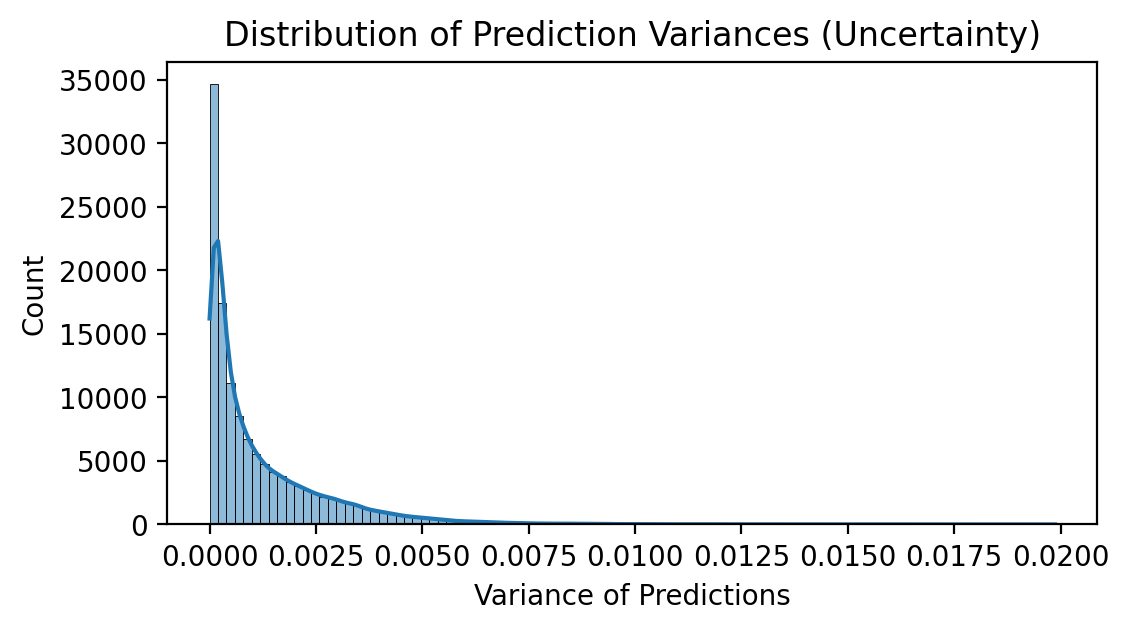

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# 1. Distribution of Prediction Uncertainties
# limit the values between 0 and 0.02 for train_res['var_p']
plt.figure(figsize=(6, 3))
sns.histplot(train_res[train_res['var_p'] < 0.02]['var_p'], bins=100, kde=True)
plt.title('Distribution of Prediction Variances (Uncertainty)')
plt.xlabel('Variance of Predictions')
plt.ylabel('Count')
plt.show()

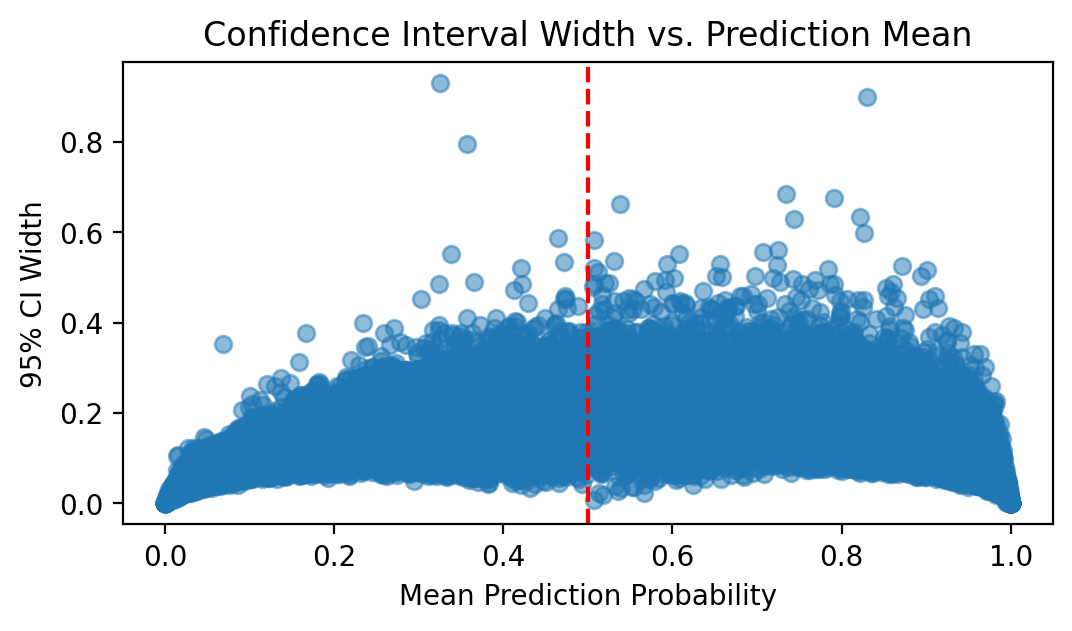

In [ ]:
# 2. Confidence Interval Width vs. Prediction Mean
plt.figure(figsize=(6, 3))
ci_width = train_res['ci_upper'] - train_res['ci_lower']
plt.scatter(train_res['mean_p'], ci_width, alpha=0.5)
plt.title('Confidence Interval Width vs. Prediction Mean')
plt.xlabel('Mean Prediction Probability')
plt.ylabel('95% CI Width')
plt.axvline(0.5, color='red', linestyle='--')
plt.show()

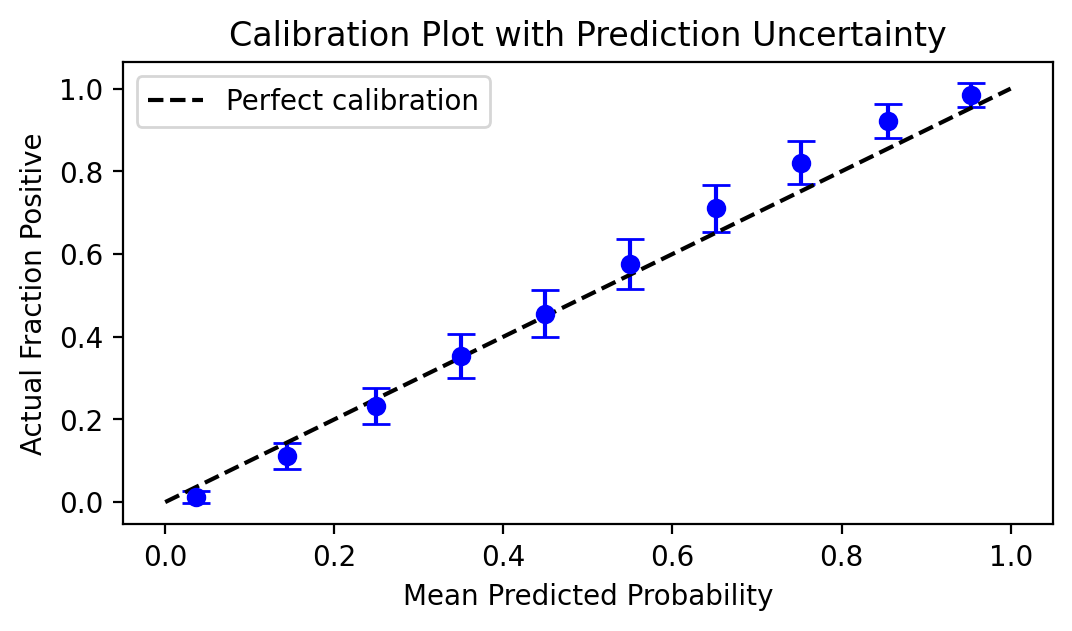

In [ ]:
# 3. Calibration Plot with Uncertainty
plt.figure(figsize=(6, 3))
bins = np.linspace(0, 1, 11)
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_means = []
bin_variances = []

for i in range(len(bins)-1):
    mask = (train_res['mean_p'] >= bins[i]) & (train_res['mean_p'] < bins[i+1])
    bin_data = train_res[mask]
    if len(bin_data) > 0:
        # Actual fraction of positive class
        actual_frac = np.mean(bin_data['true_label'])
        # Average predicted probability
        mean_pred = np.mean(bin_data['mean_p'])
        # Average variance
        mean_var = np.mean(bin_data['var_p'])

        plt.errorbar(mean_pred, actual_frac, yerr=np.sqrt(mean_var),
                    fmt='o', capsize=5, color='blue')

plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
plt.title('Calibration Plot with Prediction Uncertainty')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Actual Fraction Positive')
plt.legend()
plt.show()

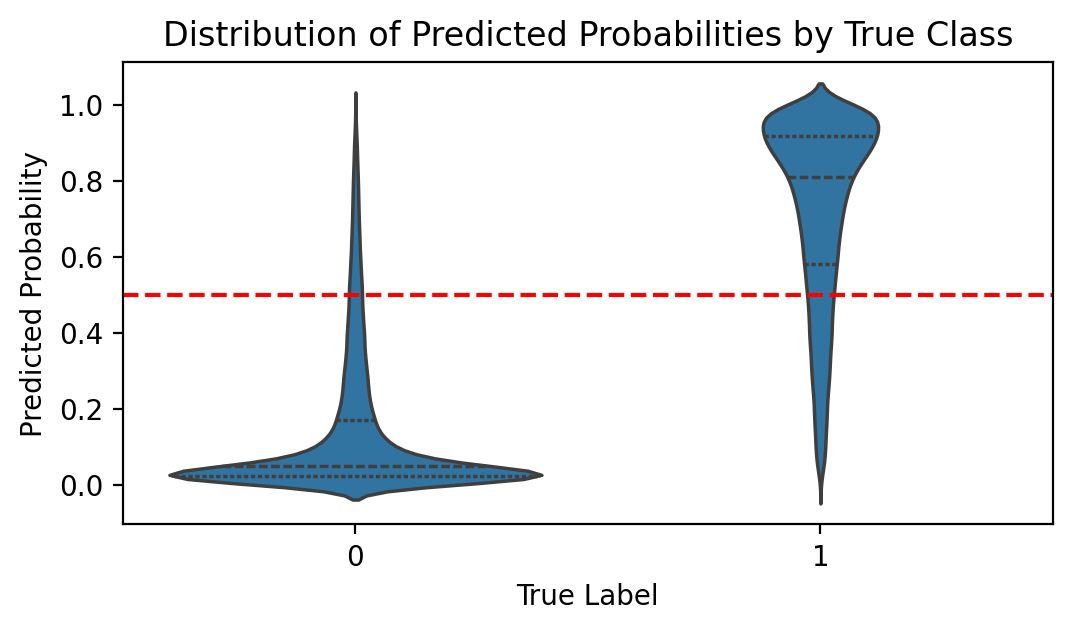

In [ ]:
# 4. Violin Plots of Prediction Distributions by True Class
plt.figure(figsize=(6, 3))
sns.violinplot(x='true_label', y='mean_p', data=train_res, inner="quartile")
plt.title('Distribution of Predicted Probabilities by True Class')
plt.xlabel('True Label')
plt.ylabel('Predicted Probability')
plt.axhline(0.5, color='red', linestyle='--')
plt.show()

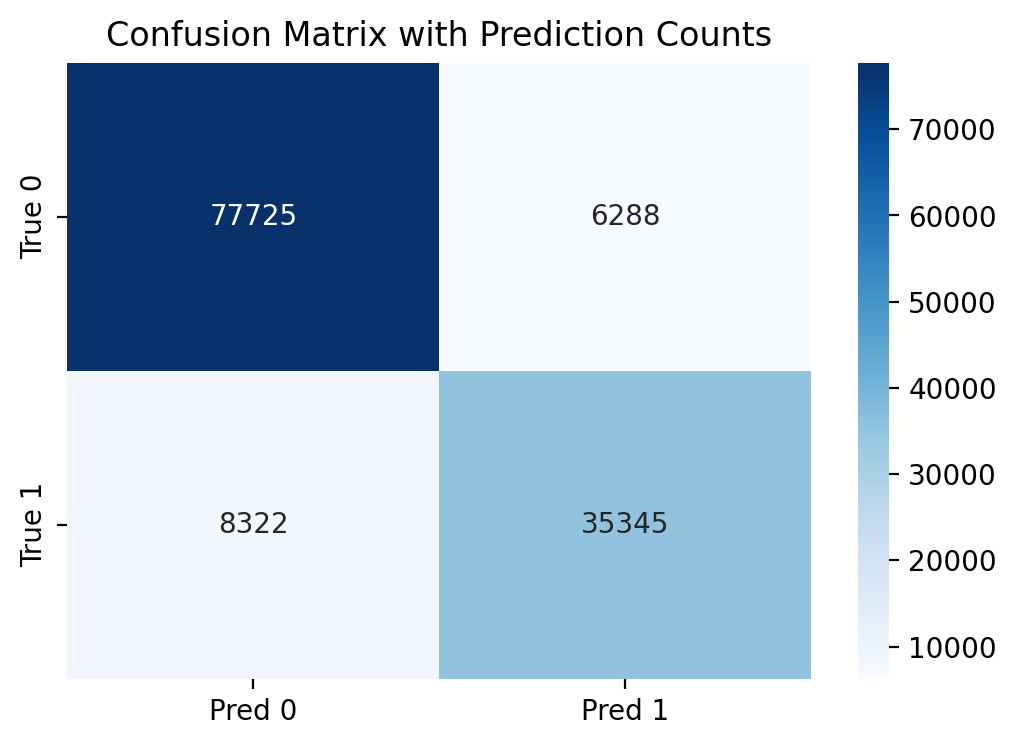

In [ ]:
# 5. Uncertainty Heatmap by Prediction and True Label
plt.figure(figsize=(6, 4))
train_res['predicted_label'] = np.round(train_res['mean_p'])
conf_mat = confusion_matrix(train_res['true_label'], train_res['predicted_label'])
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Pred 0', 'Pred 1'],
           yticklabels=['True 0', 'True 1'])
plt.title('Confusion Matrix with Prediction Counts')
plt.show()

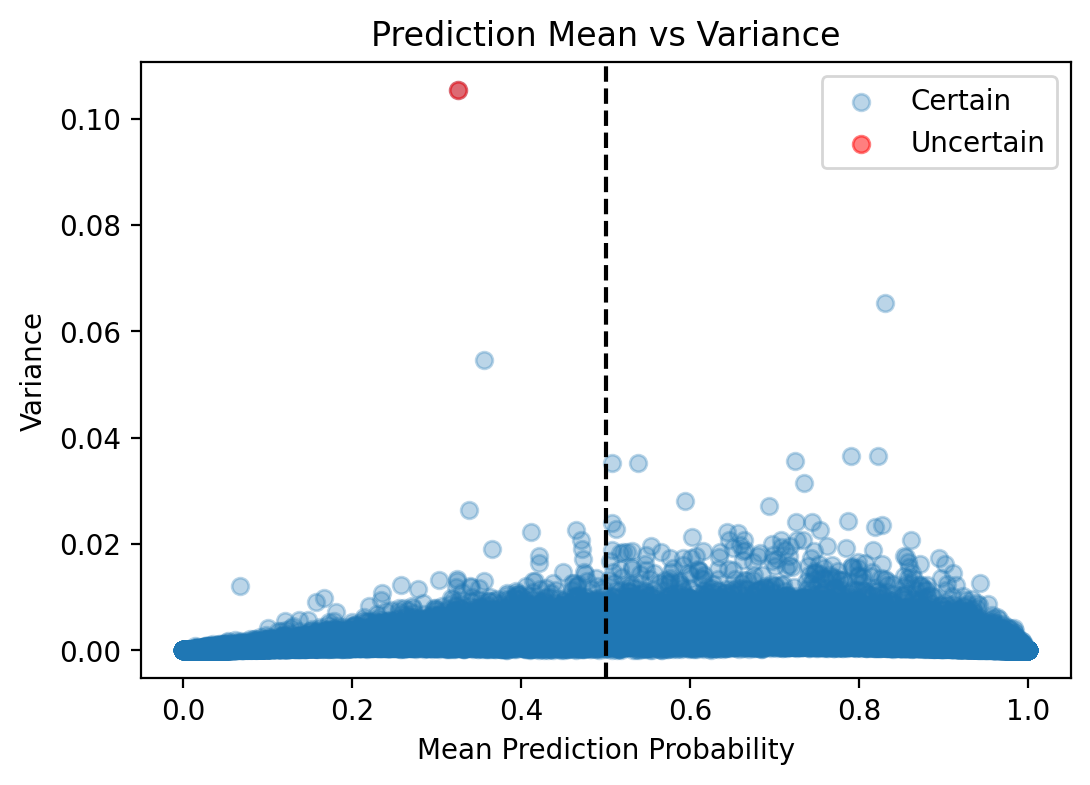

In [ ]:
# 6. Most Uncertain Predictions Analysis
uncertain_threshold = 0.1  # Variance threshold for uncertain predictions
uncertain = train_res[train_res['var_p'] > uncertain_threshold]

plt.figure(figsize=(6, 4))
plt.scatter(train_res['mean_p'], train_res['var_p'], alpha=0.3, label='Certain')
plt.scatter(uncertain['mean_p'], uncertain['var_p'], color='red', alpha=0.5, label='Uncertain')
plt.title('Prediction Mean vs Variance')
plt.xlabel('Mean Prediction Probability')
plt.ylabel('Variance')
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.show()

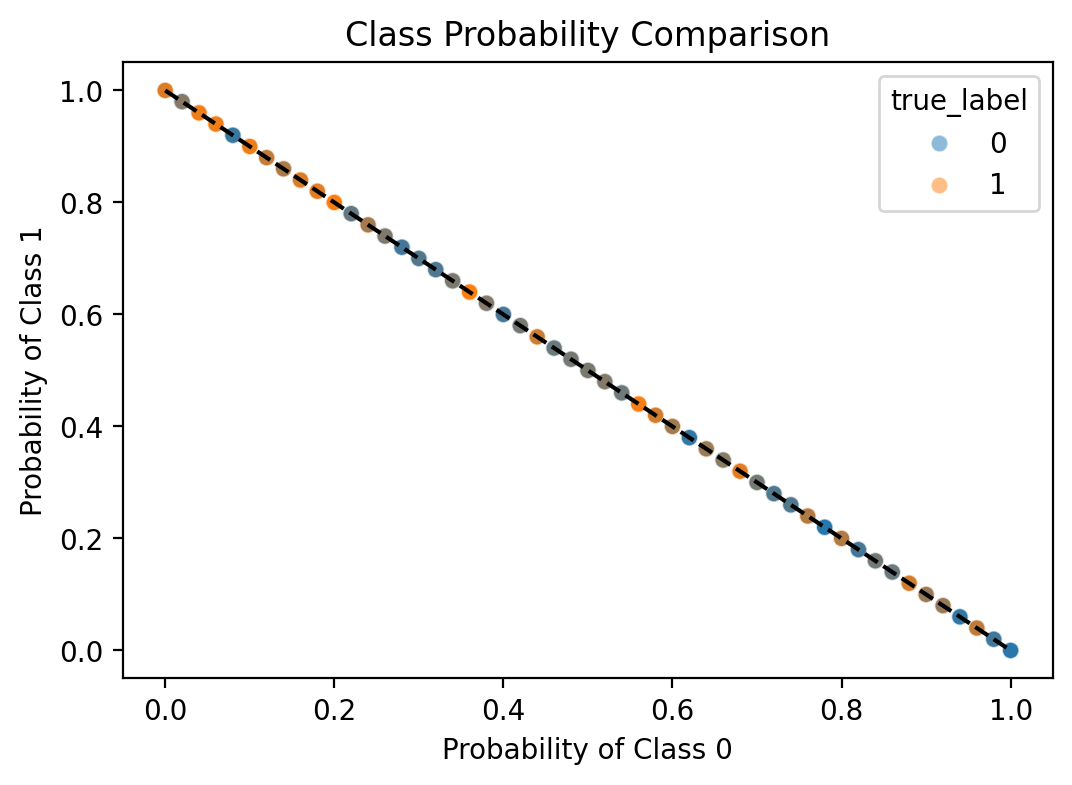

In [ ]:
# 7. Class Probability Comparison
plt.figure(figsize=(6, 4))
sns.scatterplot(x='prob0', y='prob1', hue='true_label', data=train_res, alpha=0.5)
plt.title('Class Probability Comparison')
plt.xlabel('Probability of Class 0')
plt.ylabel('Probability of Class 1')
plt.plot([0, 1], [1, 0], 'k--')  # Diagonal line
plt.show()

In [ ]:
# Assuming train_index contains the original indices for the training set
# And train_loader is your DataLoader with drop_last=True

train_dataset = train_loader.dataset
batch_size = train_loader.batch_size
num_samples_in_loader = len(train_loader) * batch_size

# Calculate the average scores for each row across all columns in train_save_out
#average_scores = np.mean(train_save_out, axis=1)
#print("Shape of average scores:", average_scores.shape)

# Get the indices that are included in the DataLoader after dropping the last batch
included_train_indices = train_index[:num_samples_in_loader]

print("Original train indices:", train_index)
print("Indices included in the train DataLoader (after dropping last batch):", included_train_indices)

train_results_df = pd.DataFrame({
    'index': included_train_indices
})
print(train_results_df.shape)
# column bind train_results_df with train_res
train_results_df = pd.concat([train_results_df, train_res], axis=1)
print(train_results_df.shape)

# Merge back with your full dataset (ds) on 'index' with ds.Column1
merged_train_results = train_results_df.merge(ds, on='index', how='left')

# save the data frame train_res to csv file
merged_train_results.to_csv('/content/drive/MyDrive/AMIC project/data/train_uncertainty.csv')

print("Merged DataFrame:")
print(merged_train_results.shape)
# Inspect
merged_train_results

Original train indices: [126513, 96328, 51255, 19448, 102796, 48044, 79800, 134806, 63750, 41011, 97136, 689, 72930, 79274, 31477, 63832, 120867, 126091, 65165, 55050, 52623, 25215, 93637, 42231, 2294, 131091, 140892, 141313, 136655, 34604, 52946, 139109, 44161, 62496, 136547, 115939, 87040, 19941, 132568, 66542, 40528, 110283, 119697, 107699, 107236, 42755, 29214, 18432, 36940, 74769, 27123, 122914, 112707, 61904, 77353, 43453, 91766, 21149, 36267, 89028, 59977, 48638, 32549, 42649, 87950, 30995, 90749, 119078, 137855, 83823, 113893, 14410, 108201, 82227, 99814, 138969, 124844, 74860, 41370, 2717, 41747, 14042, 45121, 141234, 718, 120613, 2992, 87721, 72560, 78933, 25529, 28728, 99839, 60967, 77600, 126621, 96715, 66353, 87062, 127735, 29976, 84505, 126922, 132244, 25488, 120409, 32719, 52307, 65263, 123507, 3247, 39916, 77961, 46657, 2376, 83722, 64389, 5559, 101276, 136824, 114661, 47464, 137632, 61755, 79376, 49025, 18358, 46082, 40631, 136717, 34884, 91718, 130558, 123153, 25054, 

,index,true_label,model_output,mean_p,var_p,ci_lower,ci_upper,prob1,prob0,mean_label,...,name,vintage,review_year,rating,price,reviewer,Clean_desc,Countries,Variety,label
0,126513,1,0.774113,0.763050,0.001680,0.682938,0.831176,1.00,0.00,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,96328,1,0.631434,0.628231,0.004422,0.478339,0.724528,0.96,0.04,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,51255,0,0.693451,0.699905,0.001826,0.618891,0.760362,1.00,0.00,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19448,0,0.014944,0.015617,0.000047,0.006947,0.028855,0.00,1.00,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,102796,0,0.017799,0.021533,0.000195,0.006605,0.044335,0.00,1.00,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127675,61951,0,0.037152,0.037694,0.000148,0.020004,0.071421,0.00,1.00,0,...,Bodegas Monte La Reina,2007,2010.0,83.0,4,tm,Smoke and tobacco notes wreath cherry and plum...,NaN,NaN,B
127676,31805,1,0.966972,0.956272,0.000383,0.905136,0.979711,1.00,0.00,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127677,82453,0,0.019566,0.017554,0.000091,0.008505,0.035161,0.00,1.00,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127678,132671,1,0.893843,0.928027,0.000332,0.885645,0.953151,1.00,0.00,1,...,Kistler,2008,2011.0,86.0,60,jl,"Simple, with modest ripe pear, melon and hazel...",NaN,Chardonnay,B


In [ ]:
merged_train_results[['Clean_desc', 'true_label', 'model_output']]

,Clean_desc,true_label
0,NaN,1
1,NaN,1
2,NaN,0
3,NaN,0
4,NaN,0
...,...,...
127675,Smoke and tobacco notes wreath cherry and plum...,0
127676,NaN,1
127677,NaN,0
127678,"Simple, with modest ripe pear, melon and hazel...",1


In [ ]:
output

tensor([0.0244, 0.5071, 0.0452, 0.4922, 0.0773, 0.9463, 0.0100, 0.0795, 0.0269,
        0.7099, 0.0594, 0.8901, 0.0109, 0.1660, 0.1347, 0.6598, 0.3104, 0.7808,
        0.0666, 0.0185, 0.3898, 0.0411, 0.0877, 0.3096, 0.0353, 0.4137, 0.7788,
        0.0122, 0.0115, 0.0373, 0.3697, 0.0030, 0.5411, 0.0442, 0.0574, 0.0092,
        0.0237, 0.4327, 0.0202, 0.0689, 0.0203, 0.0146, 0.0078, 0.0632, 0.0186,
        0.8109, 0.0294, 0.1515, 0.3374, 0.0037, 0.4962, 0.0487, 0.6912, 0.8241,
        0.0702, 0.0071, 0.0200, 0.4144, 0.3772, 0.0372, 0.9670, 0.0196, 0.8938,
        0.0064], device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
all_means[-1]

array([0.03491648, 0.4456996 , 0.03118974, 0.59103864, 0.08825746,
       0.91228324, 0.02459292, 0.09429254, 0.03265905, 0.6804714 ,
       0.0583276 , 0.87261516, 0.03135983, 0.16490959, 0.15842836,
       0.6273033 , 0.26176813, 0.81195   , 0.06079154, 0.03318897,
       0.45365772, 0.02650464, 0.05251651, 0.25456387, 0.02670776,
       0.2643877 , 0.91785693, 0.02225293, 0.023771  , 0.03495586,
       0.4528295 , 0.01265162, 0.54202795, 0.07583524, 0.02956655,
       0.02247371, 0.02899591, 0.46847588, 0.03117492, 0.06412674,
       0.04321782, 0.01418368, 0.02030769, 0.04477934, 0.02063587,
       0.843673  , 0.02190733, 0.10915235, 0.2995346 , 0.01234926,
       0.73777586, 0.03594581, 0.6642727 , 0.82388717, 0.0526538 ,
       0.02090812, 0.02063121, 0.3893315 , 0.28697902, 0.0409168 ,
       0.95203274, 0.0162479 , 0.88898915, 0.02463893], dtype=float32)

In [ ]:
m_p

tensor([0.0349, 0.4457, 0.0312, 0.5910, 0.0883, 0.9123, 0.0246, 0.0943, 0.0327,
        0.6805, 0.0583, 0.8726, 0.0314, 0.1649, 0.1584, 0.6273, 0.2618, 0.8120,
        0.0608, 0.0332, 0.4537, 0.0265, 0.0525, 0.2546, 0.0267, 0.2644, 0.9179,
        0.0223, 0.0238, 0.0350, 0.4528, 0.0127, 0.5420, 0.0758, 0.0296, 0.0225,
        0.0290, 0.4685, 0.0312, 0.0641, 0.0432, 0.0142, 0.0203, 0.0448, 0.0206,
        0.8437, 0.0219, 0.1092, 0.2995, 0.0123, 0.7378, 0.0359, 0.6643, 0.8239,
        0.0527, 0.0209, 0.0206, 0.3893, 0.2870, 0.0409, 0.9520, 0.0162, 0.8890,
        0.0246], device='cuda:0')

In [ ]:
v_p

tensor([2.8720e-04, 2.2709e-03, 1.4938e-04, 1.7635e-03, 4.7293e-04, 1.3330e-03,
        2.0376e-04, 4.8469e-04, 1.2411e-04, 8.7681e-04, 5.0716e-04, 2.2285e-03,
        4.9146e-04, 2.2269e-03, 6.7003e-04, 1.6544e-03, 2.0931e-03, 4.8114e-03,
        5.0972e-04, 2.2680e-04, 6.0402e-03, 2.1348e-04, 2.8672e-04, 1.2846e-03,
        8.3903e-05, 2.2417e-03, 5.7476e-04, 8.8656e-05, 1.4177e-04, 1.0607e-04,
        4.6737e-03, 3.4608e-05, 2.4491e-03, 3.3859e-04, 2.0878e-04, 2.0213e-04,
        2.7616e-04, 8.5356e-04, 2.0526e-04, 9.1474e-04, 2.0689e-04, 4.8641e-05,
        9.4026e-05, 2.7718e-04, 9.6048e-05, 3.0048e-03, 5.3522e-05, 1.3888e-03,
        1.1366e-03, 3.3355e-05, 1.4039e-03, 1.6080e-04, 6.9989e-04, 1.2042e-03,
        3.7276e-04, 6.4563e-05, 1.1929e-04, 1.6056e-03, 1.6833e-03, 1.8638e-04,
        3.1952e-04, 6.2936e-05, 5.2881e-04, 1.8803e-04], device='cuda:0')

In [ ]:
a_p

tensor([[0.0132, 0.4226, 0.0340,  ..., 0.0102, 0.8693, 0.0294],
        [0.0241, 0.5261, 0.0223,  ..., 0.0113, 0.8929, 0.0236],
        [0.0288, 0.4094, 0.0375,  ..., 0.0078, 0.8946, 0.0118],
        ...,
        [0.0207, 0.3903, 0.0224,  ..., 0.0100, 0.8691, 0.0170],
        [0.0193, 0.5062, 0.0297,  ..., 0.0099, 0.9258, 0.0549],
        [0.0255, 0.4033, 0.0168,  ..., 0.0176, 0.8716, 0.0151]],
       device='cuda:0')

In [ ]:
a_p[:, 0]

tensor([0.0132, 0.0241, 0.0288, 0.0401, 0.0313, 0.0601, 0.0185, 0.0374, 0.0281,
        0.0257, 0.0176, 0.0348, 0.0462, 0.0398, 0.0526, 0.0226, 0.0164, 0.0360,
        0.0266, 0.0222, 0.0407, 0.0640, 0.0290, 0.0295, 0.0399, 0.0191, 0.0817,
        0.0159, 0.0161, 0.0519, 0.0245, 0.0641, 0.0903, 0.0161, 0.0373, 0.0455,
        0.0468, 0.0573, 0.0273, 0.0237, 0.0444, 0.0304, 0.0353, 0.0378, 0.0270,
        0.0452, 0.0172, 0.0207, 0.0193, 0.0255], device='cuda:0')

In [ ]:
# calculate the mean and variance of the first column in a_p with tensor method
print(a_p[:, 0].mean())
print(a_p[:, 0].var())

tensor(0.0349, device='cuda:0')
tensor(0.0003, device='cuda:0')


In [ ]:
# Access the fc1 layer
fc1_layer = mb2.fc1

# Extract weights and bias
weights = fc1_layer.weight
bias = fc1_layer.bias

# Print the shapes to verify
print("Weights shape:", weights.shape)
print("Bias shape:", bias.shape)

# Save weights and bias
torch.save(weights, './attention/mb2.fc1.weights_100.pt')
torch.save(bias, './attention/mb2.fc1.bias_100.pt')

Weights shape: torch.Size([300])
Bias shape: torch.Size([1])


In [ ]:
# Access the fc2 layer
fc2_layer = mb1.fc2

# Extract weights and bias
weights = fc2_layer.weight
bias = fc2_layer.bias

# Print the shapes to verify
print("Weights shape:", weights.shape)
print("Bias shape:", bias.shape)

# Save weights and bias
torch.save(weights, './attention/mb1.fc2.weights_100.pt')
torch.save(bias, './attention/mb1.fc2.bias_100.pt')

Weights shape: torch.Size([300])
Bias shape: torch.Size([1])


In [ ]:
# Save class instances for mb1, mb2, mb3, mb0
import pickle
with open('./attention/mb1.pkl', 'wb') as f:
    pickle.dump(mb1, f)

with open('./attention/mb2.pkl', 'wb') as f:
    pickle.dump(mb2, f)

with open('./attention/mb3.pkl', 'wb') as f:
    pickle.dump(mb3, f)

with open('./attention/mb0.pkl', 'wb') as f:
    pickle.dump(mb0, f)

In [ ]:
len(all_attention_weights_P)
all_attention_weights_P[0].shape

(64, 100, 300)

In [ ]:
# get current working directory
os.getcwd()

'/content/drive/MyDrive/AMIC project'


## Prediction on validation set

In [ ]:
%%time
validation_losses = [] # track loss
num_correct = 0
mb1.eval()
mb2.eval()
mb3.eval()
mb0.eval()

# iterate over val data
test_mask=[]
outcome = []
masks = []

train_on_gpu = True
use_mask = True

criterion = nn.BCELoss()

val_word_pred = np.zeros((pad_embedding_matrix.shape[0],2))
val_mask_counter  = np.zeros((pad_embedding_matrix.shape[0],2))

val_word_dist =[[] for x in range(pad_embedding_matrix.shape[0])]
val_mask_dist = [[] for x in range(pad_embedding_matrix.shape[0])]

val_word_dist_rat0 =[[] for x in range(pad_embedding_matrix.shape[0])]
val_mask_dist_rat0 = [[] for x in range(pad_embedding_matrix.shape[0])]

val_word_dist_rat1 =[[] for x in range(pad_embedding_matrix.shape[0])]
val_mask_dist_rat1 = [[] for x in range(pad_embedding_matrix.shape[0])]

results = []
all_predictions = []
all_means = []
all_vars  = []


if(train_on_gpu):
    mb1.to(device)
    mb2.to(device)
    mb3.to(device)
    mb0.to(device)


for batch_i,(inputs, labels) in enumerate(valid_loader):
    if batch_i % 20 == 0:
        print(f"begin batch {batch_i}")
    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    # get predicted outputs
    inputs = inputs.type(torch.LongTensor).to(device)

    texts, digits = inputs[:,0:pad_size], inputs[:,pad_size:(pad_size + digits_dim + 1)] #the last dimension is for input length

    embeds, mask_1= mb0(texts)
    mask_out, p1, p3, mean_mask = mb2(embeds,mask_1, digits)
    sent_out, save_out_sent, save_out0_sent = mb1(embeds,mask_1, mask_out, digits)
    output, p2, save_out = mb3(sent_out, digits, mask_out,use_mask )

    # apply the function mc_dropout_predict() mb3
    a_p, m_p, v_p = mc_dropout_predict(model=mb3, sent=sent_out, digits=digits, mask=mask_out, use_mask=use_mask, T=50, device=device)

    # 3) move everything to CPU/NumPy
    samples_np = a_p.detach().cpu().numpy()      # shape (T, B)
    det_out_np = output.detach().cpu().numpy()   # shape (B,)
    labels_np  = labels.detach().cpu().numpy()   # shape (B,)

    # 4) loop over each example in the batch
    B = samples_np.shape[1]
    for i in range(B):
        samp_i = samples_np[:, i]             # (T,)
        stats  = summarize_mc_samples(samp_i) # dict with mean_p, var_p, ci_95%, prob1, etc.

        row = {
            'true_label':   labels_np[i],
            'model_output': det_out_np[i],
            'mean_p':       stats['mean_p'],
            'var_p':        stats['var_p'],
            'ci_lower':     stats['ci_95%'][0],
            'ci_upper':     stats['ci_95%'][1],
            'prob1':        stats['prob1'],
            'prob0':        stats['prob0'],
            'mean_label':   stats['label'],
            'certain':      stats['certain?']
        }
        results.append(row)

    # collect
    all_predictions.append(a_p.cpu().detach().numpy())
    all_means.append(m_p.cpu().detach().numpy())
    all_vars.append(v_p.cpu().detach().numpy())

    mask_out = mask_out.detach()

    mask_out = mask_out.detach().to('cpu').numpy()
    norms = torch.norm(save_out,p=1,dim = 1).pow(0.5).detach().cpu().numpy()  #normalize sentiment output by sqrt of sentence l1
    save_out = save_out.detach().to('cpu').numpy()
    inputs_tmp = inputs.to('cpu').numpy()


    sums = 0
    word_c = 0
    for b_i in range(mask_out.shape[0]):
        length = digits[b_i,digits_dim -1].to('cpu').numpy()
        word_c += length
        tmp = mask_out[b_i][(pad_size - length - 1):pad_size]
        sums += np.sum(tmp)

    mean_mask1 = sums / word_c

#     for id1, doc in enumerate(inputs_tmp[:,:100]):
#         for id2, word in enumerate(doc):
#             val_word_pred[word,0] += save_out[id1,id2]
#             val_word_pred[word,1] += 1

#             if mask_out[id1,id2]>0.5:
#                 val_mask_counter[word,0] +=  1
#             else:
#                 val_mask_counter[word,1] +=  1

#             val_word_dist[word].append(save_out[id1,id2])
#             val_mask_dist[word].append(mask_out[id1,id2])

#             if labels[id1] == 0:
#               val_word_dist_rat0[word].append(save_out[id1,id2])
#               val_mask_dist_rat0[word].append(mask_out[id1,id2])
#             else:
#               val_word_dist_rat1[word].append(save_out[id1,id2])
#               val_mask_dist_rat1[word].append(mask_out[id1,id2])


    masks.append(mean_mask1)

    # calculate loss
    validation_loss = criterion(output.squeeze(), labels.float())
    validation_losses.append(validation_loss.item())

    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer

    outcome.extend(pred.detach().to('cpu').numpy())

    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Validation loss: {:.4f}".format(np.mean(validation_losses)))
print("Mean_mask: {:.4f}".format(np.mean(masks)))
# accuracy over all test data
validation_acc = num_correct/(len(valid_loader.dataset)//batch_size * batch_size)
print("Validation accuracy: {:.4f}".format(validation_acc))

# … after your loop finishes …
val_res = pd.DataFrame(results)
print(val_res.head())

# Save val_res
val_res.to_csv('/content/drive/MyDrive/AMIC project/data/val_uncertainty.csv')

begin batch 0
begin batch 20
begin batch 40
begin batch 60
begin batch 80
begin batch 100
Validation loss: 0.2882
Mean_mask: 0.0669
Validation accuracy: 0.8760
   true_label  model_output    mean_p     var_p  ci_lower  ci_upper  prob1  \
0           0      0.065700  0.067286  0.000407  0.041268  0.107272   0.00   
1           0      0.023766  0.024425  0.000091  0.011804  0.047316   0.00   
2           0      0.006868  0.007446  0.000018  0.002833  0.017767   0.00   
3           1      0.871350  0.869922  0.001330  0.787542  0.913863   1.00   
4           1      0.481648  0.476610  0.007208  0.304778  0.581502   0.54   

   prob0  mean_label  certain  
0   1.00           0     True  
1   1.00           0     True  
2   1.00           0     True  
3   0.00           1     True  
4   0.46           0    False  
CPU times: user 2.96 s, sys: 28.1 ms, total: 2.98 s
Wall time: 2.97 s


## Prediction on the test set

V_0_* :mask applied before sentiment attention
V_1_*: mask applied after sentiemnt attention
V_2_*: no attention for masking block

without premasking in sentiemnt block

v_1_0
Test loss: 0.2541
Mean_mask: 0.2575
Test accuracy: 0.8863

v_1_1

Test loss: 0.2541
Mean_mask: 0.2575
Test accuracy: 0.8863

oss_p = loss + torch.mean(p1*0.001).squeeze()+ torch.mean(p3*0.002)  +(torch.mean(p2*0.00015)).squeeze()

V0
Test loss: 0.2540
Mean_mask: 0.2522
Test accuracy: 0.8870

v1
Test loss: 0.2541
Mean_mask: 0.2461
Test accuracy: 0.8867

V2

Test loss: 0.2592
Mean_mask: 0.0973
Test accuracy: 0.8853
torch.mean(p1*0.01).squeeze()+ torch.mean(p3*0.03).squeeze() + (torch.mean(p4*0.00015)).squeeze() +(torch.mean(p2*0.00015)).squeeze()

V3

Test loss: 0.2592
Mean_mask: 0.0973
Test accuracy: 0.8853
 torch.mean(p1*0.0015).squeeze()+ torch.mean(p3*0.03).squeeze() + (torch.mean(p4*0.00015)).squeeze() +(torch.mean(p2*0.00015)).squeeze()

v4
Test loss: 0.3071
Mean_mask: 0.2602
Test accuracy: 0.8874
loss_p = loss + torch.mean(p1*0.01).squeeze()+ torch.mean(p3*0.02)  +(torch.mean(p2*0.0015)).squeeze() + (torch.mean(p4*0.001)).squeeze() +(torch.mean(p2*0.001)).squeeze()


In [ ]:
%%time
test_losses = [] # track loss
num_correct = 0
mb1.eval()
mb2.eval()
mb3.eval()
mb0.eval()

# iterate over test data
test_mask=[]
outcome = []
y_labels = []
masks = []

train_on_gpu = True
use_mask = True

criterion = nn.BCELoss()

test_word_pred = np.zeros((pad_embedding_matrix.shape[0],2))
test_value_pred = np.zeros((pad_embedding_matrix.shape[0],2))

test_mask_counter  = np.zeros((pad_embedding_matrix.shape[0],2))

test_word_dist =[[] for x in range(pad_embedding_matrix.shape[0])]
test_mask_dist = [[] for x in range(pad_embedding_matrix.shape[0])]

test_word_dist_rat0 =[[] for x in range(pad_embedding_matrix.shape[0])]
test_mask_dist_rat0 = [[] for x in range(pad_embedding_matrix.shape[0])]

test_word_dist_rat1 =[[] for x in range(pad_embedding_matrix.shape[0])]
test_mask_dist_rat1 = [[] for x in range(pad_embedding_matrix.shape[0])]

# create an 2d empty numpy array to collect each batch save_out into one container
test_save_out = np.zeros((len(test_loader.dataset), pad_size))

results = []
all_predictions = []
all_means = []
all_vars  = []

if(train_on_gpu):
    mb1.to(device)
    mb2.to(device)
    mb3.to(device)
    mb0.to(device)


for batch_i,(inputs, labels) in enumerate(test_loader):
    if batch_i %20 == 0:
        print(f"begin batch {batch_i}")
    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    # get predicted outputs
    inputs = inputs.type(torch.LongTensor).to(device)

    texts, digits = inputs[:,0:pad_size], inputs[:,pad_size:(pad_size + digits_dim + 1)] #the last dimension is for input length

    embeds , mask_1= mb0(texts)
    mask_out, p1,p3, mean_mask = mb2(embeds,mask_1, digits)
    sent_out, save_out_sent, save_out0_sent = mb1(embeds,mask_1, mask_out, digits)
    output , p2, save_out = mb3(sent_out, digits, mask_out,use_mask )

    # apply the function mc_dropout_predict() mb3
    a_p, m_p, v_p = mc_dropout_predict(model=mb3, sent=sent_out, digits=digits, mask=mask_out, use_mask=use_mask, T=50, device=device)

    # 3) move everything to CPU/NumPy
    samples_np = a_p.detach().cpu().numpy()      # shape (T, B)
    det_out_np = output.detach().cpu().numpy()   # shape (B,)
    labels_np  = labels.detach().cpu().numpy()   # shape (B,)

    # 4) loop over each example in the batch
    B = samples_np.shape[1]
    for i in range(B):
        samp_i = samples_np[:, i]             # (T,)
        stats  = summarize_mc_samples(samp_i) # dict with mean_p, var_p, ci_95%, prob1, etc.

        row = {
            'true_label':   labels_np[i],
            'model_output': det_out_np[i],
            'mean_p':       stats['mean_p'],
            'var_p':        stats['var_p'],
            'ci_lower':     stats['ci_95%'][0],
            'ci_upper':     stats['ci_95%'][1],
            'prob1':        stats['prob1'],
            'prob0':        stats['prob0'],
            'mean_label':   stats['label'],
            'certain':      stats['certain?']
        }
        results.append(row)

    # collect
    all_predictions.append(a_p.cpu().detach().numpy())
    all_means.append(m_p.cpu().detach().numpy())
    all_vars.append(v_p.cpu().detach().numpy())

    mask_out = mask_out.detach()
    values_out  = mask_out.detach().to('cpu').numpy()
    mask_out = mask_out.detach().to('cpu').numpy()
    norms = torch.norm(save_out,p=1,dim = 1).pow(0.5).detach().cpu().numpy()  #normalize sentiment output by sqrt of sentence l1
    save_out = save_out.detach().to('cpu').numpy()
    inputs_tmp = inputs.to('cpu').numpy()
    # stack each batch save_out into the test_save_out
    test_save_out[batch_i*batch_size:(batch_i+1)*batch_size,0:pad_size] = save_out


    sums = 0
    word_c = 0
    for b_i in range(mask_out.shape[0]):
        length = digits[b_i,digits_dim -1].to('cpu').numpy()
        word_c += length
        tmp = mask_out[b_i][(pad_size - length - 1):pad_size]
        sums += np.sum(tmp)

    mean_mask1 = sums / word_c

    for id1, doc in enumerate(inputs_tmp[:,:100]):
        for id2, word in enumerate(doc):
            test_word_pred[word,0] += save_out[id1,id2]
            test_word_pred[word,1] += 1

            test_value_pred[word,0] += values_out[id1,id2]
            test_value_pred[word,1] += 1

            if mask_out[id1,id2]>0.5:
                test_mask_counter[word,0] +=  1
            else:
                test_mask_counter[word,1] +=  1

            test_word_dist[word].append(save_out[id1,id2])
            test_mask_dist[word].append(mask_out[id1,id2])

            if labels[id1] == 0:
                test_word_dist_rat0[word].append(save_out[id1,id2])
                test_mask_dist_rat0[word].append(mask_out[id1,id2])
            else:
                test_word_dist_rat1[word].append(save_out[id1,id2])
                test_mask_dist_rat1[word].append(mask_out[id1,id2])


    masks.append(mean_mask1)

    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())

    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer

    outcome.extend(pred.detach().to('cpu').numpy())
    y_labels.extend(labels.float().cpu().numpy())
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.4f}".format(np.mean(test_losses)))
print("Mean_mask: {:.4f}".format(np.mean(masks)))
# accuracy over all test data
test_acc = num_correct/(len(test_loader.dataset)//batch_size * batch_size)
print("Test accuracy: {:.4f}".format(test_acc))

# … after your loop finishes …
test_res = pd.DataFrame(results)
print(test_res.head())

# Save val_res
val_res.to_csv('/content/drive/MyDrive/AMIC project/data/test_uncertainty.csv')

begin batch 0
begin batch 20
begin batch 40
begin batch 60
begin batch 80
begin batch 100
Test loss: 0.2845
Mean_mask: 0.0666
Test accuracy: 0.8822
   true_label  model_output    mean_p     var_p  ci_lower  ci_upper  prob1  \
0           1      0.935632  0.929638  0.000852  0.852285  0.963383    1.0   
1           1      0.357479  0.363037  0.002805  0.257835  0.449483    0.0   
2           0      0.171720  0.177648  0.000687  0.132445  0.240988    0.0   
3           0      0.031886  0.034225  0.000182  0.016832  0.065272    0.0   
4           0      0.007867  0.007782  0.000020  0.003113  0.017918    0.0   

   prob0  mean_label  certain  
0    0.0           1     True  
1    1.0           0     True  
2    1.0           0     True  
3    1.0           0     True  
4    1.0           0     True  
CPU times: user 33.8 s, sys: 106 ms, total: 33.9 s
Wall time: 33.8 s
